# ⚠️ Note on Scope: U.S.-Only Implementation

This notebook demonstrates the complete data processing and analysis workflow for **the United States (USA)**.

While similar analyses have been conducted for **China** and **Europe**, only the U.S. version is included here for clarity and reproducibility.

✅ **The methodology and code structure are consistent across all regions.**  
The only differences lie in:
- Input data files (e.g., CSVs, shapefiles)
- Regional identifiers (e.g., county codes, administrative levels)
- Data sources and file paths

Therefore, this U.S. example serves as a **fully representative template** for understanding and replicating the analysis in other regions.

All steps — including data merging, normalization, city-level aggregation, and matching level calculation — follow the same logic globally.

In [2]:
import pandas as pd

# Original file path and new UTF-8 encoded file path
original_csv_file = 'USAalt_fuel_stations2024.csv'
utf8_encoded_csv_file = 'USAalt_fuel_stations2024_utf8.csv'

try:
    # Read the original file using ISO-8859-1 encoding
    df = pd.read_csv(original_csv_file, encoding='ISO-8859-1')

    # Write the data into a new CSV file encoded in UTF-8
    df.to_csv(utf8_encoded_csv_file, index=False, encoding='utf-8')

    print("File has been successfully converted to UTF-8.")
except Exception as e:
    print(f"An error occurred: {e}")

File has been successfully converted to UTF-8.


# csv file adds Solar data

In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import Point

# File paths
csv_file = 'USAalt_fuel_stations2024_utf8.csv'
tiff_file_east = 'USA_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF/eastern-hemisphere/GHI.tif'#from External data
tiff_file_west = 'USA_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF/western-hemisphere/GHI.tif'#from External data

# Step 1: Read the U.S. charging station data
charging_stations = pd.read_csv(csv_file)

# Convert to a GeoDataFrame and set the coordinate reference system
charging_stations['geometry'] = charging_stations.apply(
    lambda row: Point(row['Longitude'], row['Latitude']), axis=1
)
gdf_charging_stations = gpd.GeoDataFrame(charging_stations, geometry='geometry', crs="EPSG:4326")

# Step 2: Since all U.S. sites are in the western hemisphere, we don't need to split east and west
# Extract GHI values for charging station locations
def extract_ghi_values(tiff_file, stations_gdf):
    """Extract GHI values from the raster for a set of points in a GeoDataFrame."""
    ghi_values = []
    with rasterio.open(tiff_file) as src:
        # Extract coordinates for all stations
        station_coords = [(point.x, point.y) for point in stations_gdf.geometry]
        
        # Use Rasterio's sample method to extract GHI values
        for value in src.sample(station_coords):
            ghi_values.append(value[0] if not all(v == 0 for v in value) else None)
    
    return ghi_values

# Extract GHI values for all U.S. stations (they are all located in the western hemisphere)
gdf_charging_stations['GHI_value'] = extract_ghi_values(tiff_file_west, gdf_charging_stations)

# Step 3: Output the processed data
print(gdf_charging_stations[['Station Name', 'City', 'Latitude', 'Longitude', 'GHI_value']])

# Save to CSV file
df_charging_stations = pd.DataFrame(gdf_charging_stations.drop(columns='geometry'))
df_charging_stations.to_csv("USAalt_fuel_stations_with_GHI.csv", index=False, encoding='utf-8')

# csv file adds Wind data

In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import Point

# File paths
existing_csv_file = 'USAalt_fuel_stations_with_GHI.csv'
merged_tif_file = r'USA_power-density_10m.tif'  # From external data
output_file = 'USAalt_fuel_stations_with_GHI_and_PowerDensity1.csv'

# Step 1: Read the CSV file containing GHI values
charging_stations = pd.read_csv(existing_csv_file, encoding='utf-8')

# Convert charging station data to a GeoDataFrame with geometry and coordinate reference system
charging_stations['geometry'] = charging_stations.apply(
    lambda row: Point(row['Longitude'], row['Latitude']), axis=1
)
gdf_charging_stations = gpd.GeoDataFrame(charging_stations, geometry='geometry', crs="EPSG:4326")

# Function to extract power density values from the raster for a set of points in a GeoDataFrame.
def extract_power_density_values(tiff_file, stations_gdf):
    """Extract power density values from the raster for a set of points in a GeoDataFrame."""
    power_density_values = []
    with rasterio.open(tiff_file) as src:
        # Extract coordinates for all station points
        station_coords = [(point.x, point.y) for point in stations_gdf.geometry]
        
        # Use Rasterio's sample method to extract power density values
        for value in src.sample(station_coords):
            power_density_values.append(value[0] if not all(v == 0 for v in value) else None)
    
    return power_density_values

# Step 2: Extract Power Density values for all U.S. stations
gdf_charging_stations['Power_Density'] = extract_power_density_values(merged_tif_file, gdf_charging_stations)

# Step 3: Display selected columns of the processed data
print(gdf_charging_stations[['Station Name', 'City', 'Latitude', 'Longitude', 'GHI_value', 'Power_Density']])

# Step 4: Save the processed data to a new CSV file with UTF-8 encoding
df_charging_stations = pd.DataFrame(gdf_charging_stations.drop(columns='geometry'))
df_charging_stations.to_csv(output_file, index=False, encoding='utf-8')

# Step 5: Print the output file location
print("Charging stations with GHI and power density saved to:", output_file)

# Introduce urban boundaries

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import json

# File paths
city_boundaries_path = 'merged_city_boundariesUSCounties2.shp'  # Shapefile of U.S. city boundaries (from external data)
charging_station_data_path = 'USAalt_fuel_stations_with_GHI_and_PowerDensity1.csv'  # Charging station data
output_geojson_file = 'US_city_boundaries_with_charging_stations_filtered.geojson'  # Output GeoJSON file
output_csv_file = 'USA_charging_stations_filtered.csv'  # Output CSV file

# Read city boundary data
gdf_cities = gpd.read_file(city_boundaries_path, engine='pyogrio')

# Read charging station data
df_charging_stations = pd.read_csv(charging_station_data_path)

# Convert latitude and longitude to Point geometry objects
geometry = [Point(xy) for xy in zip(df_charging_stations['Longitude'], df_charging_stations['Latitude'])]
gdf_charging_stations = gpd.GeoDataFrame(df_charging_stations, geometry=geometry)

# Ensure the charging station data uses the same CRS as the city boundaries
gdf_charging_stations = gdf_charging_stations.set_crs(gdf_cities.crs, allow_override=True)

# Perform spatial join: associate charging stations with city boundaries
gdf_with_stations = gpd.sjoin(
    gdf_charging_stations,
    gdf_cities[['STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME', 'geometry']],
    how="inner", 
    predicate='within'
)

# Define a function to check if all stations in a city have identical GHI_value or Power_Density
def check_any_same(group):
    if len(group) == 0:
        return False
    ghivalue_values = group['GHI_value'].unique()
    power_density_values = group['Power_Density'].unique()
    return len(ghivalue_values) == 1 or len(power_density_values) == 1

# Apply the function to identify cities where all values are the same (to be excluded)
cities_to_exclude = gdf_with_stations.groupby(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME']).apply(check_any_same).reset_index(name='any_same')
cities_to_keep = cities_to_exclude[~cities_to_exclude['any_same']][['STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME']]

# Filter out charging stations located in cities that should be excluded
gdf_with_stations_filtered = gdf_with_stations.merge(cities_to_keep, on=['STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME'])

# Count the number of charging stations per city and keep only cities with at least 5 stations
stations_count = gdf_with_stations_filtered.groupby(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME']).size().reset_index(name='stations_count')
cities_with_enough_stations = stations_count[stations_count['stations_count'] >= 5][['STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME']]
gdf_with_stations_final = gdf_with_stations_filtered.merge(cities_with_enough_stations, on=['STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME'])

# Update city boundaries: keep only cities that meet the filtering criteria
gdf_cities_with_stations = gdf_cities.merge(
    stations_count[stations_count['stations_count'] >= 5], 
    on=['STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME'], 
    how='right'
)

# Convert charging station data to JSON format and store in a new column
gdf_cities_with_stations['Charging_Stations'] = gdf_cities_with_stations.apply(
    lambda row: json.dumps(
        gdf_with_stations_final[
            (gdf_with_stations_final['STATEFP'] == row['STATEFP']) &
            (gdf_with_stations_final['COUNTYFP'] == row['COUNTYFP']) &
            (gdf_with_stations_final['COUNTYNS'] == row['COUNTYNS']) &
            (gdf_with_stations_final['NAME'] == row['NAME'])
        ].drop(columns=['index_right']).apply(
            lambda station_row: {
                **station_row.to_dict(),
                'geometry': [station_row['geometry'].x, station_row['geometry'].y]  # Convert Point to [lon, lat]
            }, axis=1
        ).tolist(),
        ensure_ascii=False  # Allow non-ASCII characters (e.g., Chinese) in output
    ), axis=1
)

# Save the final GeoDataFrame with embedded station data to a GeoJSON file
gdf_cities_with_stations.drop(columns=['index_right'], errors='ignore').to_file(
    output_geojson_file, 
    driver='GeoJSON', 
    encoding='utf-8'
)

# Output debug information
print(f"Final GeoDataFrame contains {len(gdf_cities_with_stations)} cities with charging station data.")
print(f"The generated GeoJSON file is saved as: {output_geojson_file}")

# Inspect one city's charging station data (for debugging)
if not gdf_cities_with_stations.empty:
    sample_city = gdf_cities_with_stations.iloc[0]  # Select the first city as a sample
    print(f"City: {sample_city['NAME']} ({sample_city['STATEFP']}, {sample_city['COUNTYFP']}) Charging Stations Info: {sample_city['Charging_Stations']}")
else:
    print("No cities with charging stations were found.")

# Prepare and save final charging station data to CSV
df_final_stations = gdf_with_stations_final.drop(columns=['index_right']).copy()
output_columns = ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'NAME', 'Longitude', 'Latitude', 'GHI_value', 'Power_Density']
df_final_stations.to_csv(output_csv_file, columns=output_columns, index=False, encoding='utf-8-sig')

# Output completion message
print(f"Final charging station data saved as: {output_csv_file}")

# Generation of the geojson file before the calculation of the Gini coefficient

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
import numpy as np
from tqdm import tqdm
import json
import gc

# File paths (adjust according to your actual paths)
population_tif = 'merged_population_data_USAnew.tif'  # Population data from external source (segmented by age/gender)
cities_with_stations_file = 'US_city_boundaries_with_charging_stations_filtered.geojson'
final_output_geojson_file = 'allUSAOptimized_city_grids_with_population_and_stations.geojson'

# Read the GeoJSON file containing city boundaries and charging station information
cities_with_stations_gdf = gpd.read_file(cities_with_stations_file, engine='pyogrio')

# Ensure charging station data is parsed as a list of dictionaries
cities_with_stations_gdf['Charging_Stations'] = cities_with_stations_gdf['Charging_Stations'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x
)

# Define band names corresponding to population categories (e.g., age and gender groups)
band_names = ['f_20', 'f_25', 'f_30', 'f_35', 'f_40', 'f_45', 'f_50', 'f_55', 'f_60', 'f_65', 'f_70', 'f_75',
              'm_20', 'm_25', 'm_30', 'm_35', 'm_40', 'm_45', 'm_50', 'm_65', 'm_60', 'm_65', 'm_70', 'm_75']

def process_polygon(polygon, city_info, population_tif):
    """
    Process a single polygon (city or city part) to extract population grids and 
    associate charging stations within each grid cell.
    """
    results = []
    try:
        with rasterio.open(population_tif) as src:
            # Extract population raster data within the polygon
            population_data, out_transform = mask(src, [polygon], crop=True, all_touched=True, filled=True)
            
            # Identify valid raster cell indices (including zero population, excluding NaN)
            valid_mask = ~np.isnan(population_data[0])
            rows, cols = np.where(valid_mask)

            # Skip if no valid raster cells are found
            if len(rows) == 0:
                print(f"  Warning: No population data found for city {city_info['NAME']}, skipping...")
                return results

            # Create GeoDataFrame for charging stations and reproject to raster CRS
            charging_stations = city_info['Charging_Stations']
            station_points = [Point(station['geometry'][0], station['geometry'][1]) for station in charging_stations]
            stations_gdf = gpd.GeoDataFrame(
                {'Charging_Stations': charging_stations},
                geometry=station_points,
                crs="EPSG:4326"
            ).to_crs(src.crs)

            # Build spatial index for efficient querying
            stations_sindex = stations_gdf.sindex

            # Iterate over each valid raster cell
            for row, col in zip(rows, cols):
                # Calculate the extent of the current grid cell
                x_min, y_max = out_transform * (col, row)
                x_max, y_min = out_transform * (col + 1, row + 1)
                poly = Polygon([(x_min, y_max), (x_max, y_max), (x_max, y_min), (x_min, y_min)])

                # Apply a small buffer to ensure stations on cell edges are captured
                poly_buffered = poly.buffer(0.0001)  # Buffer size can be adjusted based on data resolution
                possible_matches_index = list(stations_sindex.intersection(poly_buffered.bounds))
                charging_stations_within_poly = [
                    stations_gdf.iloc[idx]['Charging_Stations']
                    for idx in possible_matches_index if stations_gdf.iloc[idx].geometry.intersects(poly_buffered)
                ]

                # Extract population values by band (age/gender group)
                population_by_band = {
                    band_names[i]: float(population_data[i, row, col])
                    for i in range(len(band_names))
                    if not np.isnan(population_data[i, row, col]) and population_data[i, row, col] >= 0
                }

                # Calculate total population in this grid cell
                total_population = sum(population_by_band.values())

                # Append the feature to results
                results.append({
                    'type': 'Feature',
                    'properties': {
                        'City': city_info['NAME'],
                        'State': city_info['STATEFP'],
                        'CountyFP': city_info['COUNTYFP'],
                        'CountyNS': city_info['COUNTYNS'],
                        'Population_By_Band': population_by_band,
                        'Total_Population': total_population,
                        'Charging_Stations': json.dumps(charging_stations_within_poly, ensure_ascii=False),
                    },
                    'geometry': poly.__geo_interface__
                })

    except Exception as e:
        print(f"  Error: Failed to process city {city_info['NAME']}: {e}")

    return results


# Initialize the output GeoJSON file
with open(final_output_geojson_file, 'w', encoding='utf-8') as f:
    f.write('{"type": "FeatureCollection", "features": [\n')

# Process each city with progress bar
for idx, city in tqdm(cities_with_stations_gdf.iterrows(), total=len(cities_with_stations_gdf), desc="Processing Cities"):
    city_info = {
        'STATEFP': city['STATEFP'],
        'COUNTYFP': city['COUNTYFP'],
        'COUNTYNS': city['COUNTYNS'],
        'NAME': city['NAME'],
        'Charging_Stations': city['Charging_Stations']
    }

    # Handle MultiPolygon geometries by processing each sub-polygon
    if city['geometry'].geom_type == 'MultiPolygon':
        for polygon in city['geometry'].geoms:
            city_results = process_polygon(polygon, city_info, population_tif)
            if city_results:
                with open(final_output_geojson_file, 'a', encoding='utf-8') as f:
                    for feature in city_results:
                        f.write(json.dumps(feature, ensure_ascii=False) + ',\n')
    # Handle single Polygon geometries
    elif city['geometry'].geom_type == 'Polygon':
        city_results = process_polygon(city['geometry'], city_info, population_tif)
        if city_results:
            with open(final_output_geojson_file, 'a', encoding='utf-8') as f:
                for feature in city_results:
                    f.write(json.dumps(feature, ensure_ascii=False) + ',\n')

    # Clean up memory
    del city_results
    gc.collect()

# Finalize the GeoJSON file: remove trailing comma and close the JSON structure
with open(final_output_geojson_file, 'r+', encoding='utf-8') as f:
    content = f.read()
    if content.endswith(',\n'):
        content = content.rstrip(',\n') + '\n'
    content += ']}'
    f.seek(0)
    f.write(content)
    f.truncate()

print(f"\nFinal result saved to: '{final_output_geojson_file}'")

# The calculation of the Gini coefficient considering renewable energy and the total population

In [ ]:
# -*- coding: utf-8 -*-

import geopandas as gpd
import pandas as pd
import json
from scipy.spatial.distance import cdist
import numpy as np
from pyproj import Transformer
import gc

# Define file paths (please adjust according to your actual setup)
input_grids_file = 'allUSAOptimized_city_grids_with_population_and_stations.geojson'

# Read GeoJSON file into a GeoDataFrame
grids_gdf = gpd.read_file(input_grids_file, engine='pyogrio')

# Convert the 'Population_By_Band' column from JSON string to dictionary
grids_gdf['Population_By_Band'] = grids_gdf['Population_By_Band'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else {}
)

# Clean population data
def clean_population_data(pop_band_dict):
    """Clean population data, remove invalid values"""
    cleaned_pop = {k: max(0, v) for k, v in pop_band_dict.items()}
    return cleaned_pop

grids_gdf['Population_By_Band'] = grids_gdf['Population_By_Band'].apply(clean_population_data)

# Merge population data to get total population
population_columns = ['f_20', 'f_25', 'f_30', 'f_35', 'f_40', 'f_45', 'f_50', 'f_55', 'f_60', 'f_65', 'f_70', 'f_75',
                      'm_20', 'm_25', 'm_30', 'm_35', 'm_40', 'm_45', 'm_50', 'm_55', 'm_60', 'm_65', 'm_70', 'm_75']

# Create a new DataFrame to store population data
population_df = pd.DataFrame(grids_gdf['Population_By_Band'].tolist())

# Fill missing bands with 0 if any
for col in population_columns:
    if col not in population_df.columns:
        population_df[col] = 0

# Ensure all population columns are non-negative
population_df = population_df.clip(lower=0)

# Calculate total population per grid
grids_gdf['Population'] = population_df.sum(axis=1).astype(np.float32)

# Gaussian decay function
def gaussian_decay(distance, d0=5):
    norm_factor = (1 - np.exp(-0.5)).astype(np.float32)
    decay_values = np.where(distance <= d0,
                            ((np.exp(-0.5 * (distance / d0) ** 2) - np.exp(-0.5)) / norm_factor).astype(np.float32),
                            0).astype(np.float32)
    return decay_values

# Coordinate projection function
def project_coordinates(lats, lons, target_crs='EPSG:3857'):
    transformer = Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
    xs, ys = transformer.transform(lons, lats)
    return np.vstack((xs, ys)).T.astype(np.float32)

# Accessibility calculation function
def calculate_accessibility_in_place(grids_gdf, supply_key, d0=5):
    if grids_gdf.empty:
        print("Note: GeoDataFrame is empty")
        return False

    station_coords = []
    supplies = []

    for idx, row in grids_gdf.iterrows():
        stations = json.loads(row['Charging_Stations']) if isinstance(row['Charging_Stations'], str) else []
        for station in stations:
            try:
                lat = float(station.get('Latitude', '0'))  # Use U.S. field names for coordinates
                lon = float(station.get('Longitude', '0'))
                supply = float(station.get(supply_key, '0')) or 0.0000001

                # Apply threshold for wind energy resources
                if supply_key == 'Power_Density' and supply < 16.5375:
                    supply = 0  # Set wind resource to 0 if below threshold

                if lat and lon and supply > 0:
                    station_coords.append((lat, lon))
                    supplies.append(supply)
            except (ValueError, TypeError):
                continue

    if not station_coords:
        print(f"Note: No valid charging station data found")
        return False

    station_coords = np.array(station_coords, dtype=np.float32)
    supplies = np.array(supplies, dtype=np.float32)

    grid_centroids = [(geom.centroid.y, geom.centroid.x) for geom in grids_gdf.geometry]
    grid_proj = project_coordinates(*zip(*grid_centroids))
    station_proj = project_coordinates(*zip(*station_coords))

    distances = cdist(grid_proj, station_proj, metric='euclidean').astype(np.float32) / 1000  
    decay_matrix = gaussian_decay(distances, d0=d0)

    population = grids_gdf['Population'].values.astype(np.float32)
    
    total_demands = decay_matrix.T @ population
    total_demands = np.where(total_demands > 0, total_demands, 1).astype(np.float32)
    R_j = (supplies / total_demands).astype(np.float32)

    accessibility = (decay_matrix @ R_j).astype(np.float32)
    accessibility_col = f'Accessibility_{supply_key}'
    grids_gdf[accessibility_col] = accessibility

    grids_gdf[accessibility_col] = grids_gdf[accessibility_col].fillna(0).astype(np.float32)

    del distances, decay_matrix, total_demands, R_j, grid_proj, station_proj, station_coords, supplies
    gc.collect()

    return True

# Gini coefficient calculation function
def calculate_gini(population, total_accessibility):
    if len(total_accessibility) == 0 or len(population) == 0:
        return 0
    
    sorted_indices = np.argsort(total_accessibility)
    sorted_population = population[sorted_indices].astype(np.float32)
    sorted_total_accessibility = total_accessibility[sorted_indices].astype(np.float32)

    sorted_total_accessibility += 0.0000001  # Add small constant to avoid zero division

    cum_population = np.cumsum(sorted_population) / sorted_population.sum()
    cum_total_accessibility = np.cumsum(sorted_total_accessibility) / sorted_total_accessibility.sum()
    
    gini = 1 - np.sum((cum_total_accessibility[1:] + cum_total_accessibility[:-1]) * \
                      (cum_population[1:] - cum_population[:-1]))

    return max(0, min(gini, 1))


# Calculate Gini coefficients for all cities
gini_results = {}

# Get unique city combinations
unique_city_combinations = grids_gdf[['State', 'CountyFP', 'CountyNS', 'City']].dropna().drop_duplicates()

for _, city_info in unique_city_combinations.iterrows():
    state, countyfp, countyns, city_name = city_info['State'], city_info['CountyFP'], city_info['CountyNS'], city_info['City']
    city_identifier = (state, countyfp, countyns, city_name)
    print(f"Processing city combination: {city_identifier}")

    # Group by city, including all grids regardless of population
    city_group = grids_gdf[(grids_gdf['State'] == state) & 
                           (grids_gdf['CountyFP'] == countyfp) & 
                           (grids_gdf['CountyNS'] == countyns) & 
                           (grids_gdf['City'] == city_name)].copy()

    if city_group.empty:
        print(f"Note: GeoDataFrame is empty for city combination {city_identifier}")
        continue

    # Calculate accessibility directly on original city grids
    for supply_key in ['Power_Density', 'GHI_value']:
        accessibility_col = f'Accessibility_{supply_key}'
        
        if calculate_accessibility_in_place(city_group, supply_key):
            # Filter out grids with zero population
            valid_population_mask = city_group['Population'] > 0
            valid_accessibility = city_group[valid_population_mask]

            if not valid_accessibility.empty and accessibility_col in valid_accessibility.columns:
                     
                # Calculate total accessibility per grid
                total_accessibility = valid_accessibility[accessibility_col] * valid_accessibility['Population']
                
                gini_coefficient = calculate_gini(valid_accessibility['Population'].values, total_accessibility.values)
                gini_results[city_identifier + (supply_key,)] = gini_coefficient
                
                print(f"City Combination: {city_identifier}, Energy Type: {supply_key}, Gini Coefficient Calculated: {gini_coefficient}")
            else:
                print(f"City Combination: {city_identifier}, Energy Type: {supply_key}, Note: No valid accessibility data for Gini calculation")
        else:
            print(f"City Combination: {city_identifier}, Energy Type: {supply_key}, Note: Accessibility calculation failed")

# Save results to file
output_file = 'gini_results_all_USA_CityCombinations_Windsolar.csv'
with open(output_file, 'w', encoding='utf-8') as f:
    f.write("State,CountyFP,CountyNS,City,Supply_Type,Gini_Coefficient\n")
    for (statefp, countyfp, countyns, name, supply_key), gini in gini_results.items():
        f.write(f"{statefp},{countyfp},{countyns},{name},{supply_key},{gini}\n")
print(f"\nGini coefficient results saved to file: '{output_file}'")

# The calculation of the Gini coefficient considering renewable energy and grouped populations

In [ ]:

# -*- coding: utf-8 -*-
"""
Created on [Your Date]

@author: ZF
"""

import geopandas as gpd
import pandas as pd
import json
from scipy.spatial.distance import cdist
import numpy as np
from pyproj import Transformer
import gc

# Define file paths (please adjust according to your actual setup)
input_grids_file = 'allUSAOptimized_city_grids_with_population_and_stations.geojson'

# Read GeoJSON file into a GeoDataFrame
grids_gdf = gpd.read_file(input_grids_file, engine='pyogrio')

# Convert the 'Population_By_Band' column from JSON string to dictionary
grids_gdf['Population_By_Band'] = grids_gdf['Population_By_Band'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else {}
)

# Parse and clean population data
def clean_population_data(pop_band_dict):
    """Clean population data, remove invalid values"""
    cleaned_pop = {k: max(0, v) for k, v in pop_band_dict.items()}
    return cleaned_pop

grids_gdf['Population_By_Band'] = grids_gdf['Population_By_Band'].apply(clean_population_data)

# Merge population data to get total population and age/gender groups
population_columns = ['f_20', 'f_25', 'f_30', 'f_35', 'f_40', 'f_45', 'f_50', 'f_55', 'f_60', 'f_65', 'f_70', 'f_75',
                      'm_20', 'm_25', 'm_30', 'm_35', 'm_40', 'm_45', 'm_50', 'm_55', 'm_60', 'm_65', 'm_70', 'm_75']

# Create a new DataFrame to store population data
population_df = pd.DataFrame(grids_gdf['Population_By_Band'].tolist())

# Fill missing bands with 0 if any
for col in population_columns:
    if col not in population_df.columns:
        population_df[col] = 0

# Ensure all population columns are non-negative
population_df = population_df.clip(lower=0)

# Group population by age and gender
age_groups = {
    '20-35': ['f_20', 'f_25', 'f_30', 'm_20', 'm_25', 'm_30'],
    '35-60': ['f_35', 'f_40', 'f_45', 'f_50', 'f_55', 'm_35', 'm_40', 'm_45', 'm_50', 'm_55'],
    '60-80': ['f_60', 'f_65', 'f_70', 'f_75', 'm_60', 'm_65', 'm_70', 'm_75']
}

gender_groups = {
    'female': [col for col in population_columns if col.startswith('f_')],
    'male': [col for col in population_columns if col.startswith('m_')]
}

# Create new columns for age and gender groups
for age_group, cols in age_groups.items():
    grids_gdf[f'Population_{age_group}'] = population_df[cols].sum(axis=1).astype(np.float32)

for gender_group, cols in gender_groups.items():
    grids_gdf[f'Population_{gender_group}'] = population_df[cols].sum(axis=1).astype(np.float32)

# Calculate total population
grids_gdf['Population'] = population_df.sum(axis=1).astype(np.float32)

# Gaussian decay function
def gaussian_decay(distance, d0=5):
    norm_factor = (1 - np.exp(-0.5)).astype(np.float32)
    decay_values = np.where(distance <= d0,
                            ((np.exp(-0.5 * (distance / d0) ** 2) - np.exp(-0.5)) / norm_factor).astype(np.float32),
                            0).astype(np.float32)
    return decay_values

# Coordinate projection function
def project_coordinates(lats, lons, target_crs='EPSG:3857'):
    transformer = Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
    xs, ys = transformer.transform(lons, lats)
    return np.vstack((xs, ys)).T.astype(np.float32)

# Accessibility calculation function (updated)
def calculate_accessibility_in_place(grids_gdf, supply_key, population_key='Population', d0=5):
    if grids_gdf.empty:
        print("Note: GeoDataFrame is empty")
        return False

    station_coords = []
    supplies = []

    for idx, row in grids_gdf.iterrows():
        stations = json.loads(row['Charging_Stations']) if isinstance(row['Charging_Stations'], str) else []
        for station in stations:
            try:
                lat = float(station.get('Latitude', '0'))  # Use U.S. field names for coordinates
                lon = float(station.get('Longitude', '0'))
                supply = float(station.get(supply_key, '0')) or 0.0000001

                # Apply threshold for wind energy resources
                if supply_key == 'Power_Density' and supply < 16.5375:
                    supply = 0  # Set wind resource to 0 if below threshold

                if lat and lon and supply > 0:
                    station_coords.append((lat, lon))
                    supplies.append(supply)
            except (ValueError, TypeError):
                continue

    if not station_coords:
        print(f"Note: No valid charging station data found")
        return False

    station_coords = np.array(station_coords, dtype=np.float32)
    supplies = np.array(supplies, dtype=np.float32)

    grid_centroids = [(geom.centroid.y, geom.centroid.x) for geom in grids_gdf.geometry]
    grid_proj = project_coordinates(*zip(*grid_centroids))
    station_proj = project_coordinates(*zip(*station_coords))

    distances = cdist(grid_proj, station_proj, metric='euclidean').astype(np.float32) / 1000  
    decay_matrix = gaussian_decay(distances, d0=d0)

    population = grids_gdf[population_key].values.astype(np.float32)
    
    total_demands = decay_matrix.T @ population
    total_demands = np.where(total_demands > 0, total_demands, 1).astype(np.float32)
    R_j = (supplies / total_demands).astype(np.float32)

    accessibility = (decay_matrix @ R_j).astype(np.float32)
    accessibility_col = f'Accessibility_{supply_key}_{population_key.split("_")[-1]}'
    grids_gdf[accessibility_col] = accessibility

    grids_gdf[accessibility_col] = grids_gdf[accessibility_col].fillna(0).astype(np.float32)

    del distances, decay_matrix, total_demands, R_j, grid_proj, station_proj, station_coords, supplies
    gc.collect()

    return True

# Gini coefficient calculation function
def calculate_gini(population, total_accessibility):
    if len(total_accessibility) == 0 or len(population) == 0:
        return 0
    
    sorted_indices = np.argsort(total_accessibility)
    sorted_population = population[sorted_indices].astype(np.float32)
    sorted_total_accessibility = total_accessibility[sorted_indices].astype(np.float32)

    sorted_total_accessibility += 0.0000001  # Add small constant to avoid zero division

    cum_population = np.cumsum(sorted_population) / sorted_population.sum()
    cum_total_accessibility = np.cumsum(sorted_total_accessibility) / sorted_total_accessibility.sum()
    
    gini = 1 - np.sum((cum_total_accessibility[1:] + cum_total_accessibility[:-1]) * \
                      (cum_population[1:] - cum_population[:-1]))

    return max(0, min(gini, 1))

# Compute Gini coefficients for all cities (updated)
gini_results = {}

# Get unique city combinations
unique_city_combinations = grids_gdf[['State', 'CountyFP', 'CountyNS', 'City']].dropna().drop_duplicates()

for _, city_info in unique_city_combinations.iterrows():
    state, countyfp, countyns, city_name = city_info['State'], city_info['CountyFP'], city_info['CountyNS'], city_info['City']
    city_identifier = (state, countyfp, countyns, city_name)
    print(f"Processing city combination: {city_identifier}")

    # Group by city, including all grids regardless of population
    city_group = grids_gdf[(grids_gdf['State'] == state) & 
                           (grids_gdf['CountyFP'] == countyfp) & 
                           (grids_gdf['CountyNS'] == countyns) & 
                           (grids_gdf['City'] == city_name)].copy()

    if city_group.empty:
        print(f"Note: GeoDataFrame is empty for city combination {city_identifier}")
        continue

    # Iterate over each supply type and demographic group
    for supply_key in ['Power_Density', 'GHI_value']:
        for group_key in list(age_groups.keys()) + list(gender_groups.keys()):
            accessibility_col = f'Accessibility_{supply_key}_{group_key}'
            
            if calculate_accessibility_in_place(city_group, supply_key, population_key=f'Population_{group_key}', d0=5):
                valid_population_mask = city_group[f'Population_{group_key}'] > 0
                valid_accessibility = city_group[valid_population_mask]

                if not valid_accessibility.empty and accessibility_col in valid_accessibility.columns:
                    # Calculate total accessibility per grid
                    total_accessibility = valid_accessibility[accessibility_col] * valid_accessibility[f'Population_{group_key}'].values
                    
                    gini_coefficient = calculate_gini(valid_accessibility[f'Population_{group_key}'].values, total_accessibility.values)
                    
                    gini_results[city_identifier + (supply_key, group_key)] = gini_coefficient
                    print(f"City Combination: {city_identifier}, Energy Type: {supply_key}, Group: {group_key}, Gini Coefficient Calculated: {gini_coefficient}")
                else:
                    print(f"City Combination: {city_identifier}, Energy Type: {supply_key}, Group: {group_key}, Note: No valid accessibility data for Gini calculation")
            else:
                print(f"City Combination: {city_identifier}, Energy Type: {supply_key}, Group: {group_key}, Note: Accessibility calculation failed")

# Save results to file
output_file = 'gini_results_all_USA_CityCombinations_Windsolar_by_groups.csv'
with open(output_file, 'w', encoding='utf-8') as f:
    f.write("State,CountyFP,CountyNS,City,Supply_Type,Group_Type,Gini_Coefficient\n")
    for (statefp, countyfp, countyns, name, supply_key, group_key), gini in gini_results.items():
        f.write(f"{statefp},{countyfp},{countyns},{name},{supply_key},{group_key},{gini}\n")
print(f"\nGini coefficient results saved to file: '{output_file}'")

#  Calculation of the Gini coefficient of the total population without considering renewable energy

In [3]:
# -*- coding: utf-8 -*-
"""
Created on [Your Date]

@author: ZF
"""

import geopandas as gpd
import pandas as pd
import json
from scipy.spatial.distance import cdist
import numpy as np
from pyproj import Transformer
import gc

# Define file paths (please adjust according to your actual setup)
input_grids_file = 'allUSAOptimized_city_grids_with_population_and_stations.geojson'

# Read GeoJSON file into a GeoDataFrame
grids_gdf = gpd.read_file(input_grids_file, engine='pyogrio')

# Convert the 'Population_By_Band' column from JSON string to dictionary
grids_gdf['Population_By_Band'] = grids_gdf['Population_By_Band'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else {}
)

# Parse and clean population data
def clean_population_data(pop_band_dict):
    """Clean population data, remove invalid values"""
    cleaned_pop = {k: max(0, v) for k, v in pop_band_dict.items()}
    return cleaned_pop

grids_gdf['Population_By_Band'] = grids_gdf['Population_By_Band'].apply(clean_population_data)

# Merge population data to get total population
population_columns = ['f_20', 'f_25', 'f_30', 'f_35', 'f_40', 'f_45', 'f_50', 'f_55', 'f_60', 'f_65', 'f_70', 'f_75',
                      'm_20', 'm_25', 'm_30', 'm_35', 'm_40', 'm_45', 'm_50', 'm_55', 'm_60', 'm_65', 'm_70', 'm_75']

# Create a new DataFrame to store population data
population_df = pd.DataFrame(grids_gdf['Population_By_Band'].tolist())

# Fill missing bands with 0 if any
for col in population_columns:
    if col not in population_df.columns:
        population_df[col] = 0

# Ensure all population columns are non-negative
population_df = population_df.clip(lower=0)

# Calculate total population for each grid
grids_gdf['Population'] = population_df.sum(axis=1).astype(np.float32)

# Gaussian decay function
def gaussian_decay(distance, d0=5):
    norm_factor = (1 - np.exp(-0.5)).astype(np.float32)
    decay_values = np.where(distance <= d0,
                            ((np.exp(-0.5 * (distance / d0) ** 2) - np.exp(-0.5)) / norm_factor).astype(np.float32),
                            0).astype(np.float32)
    return decay_values

# Coordinate projection function
def project_coordinates(lats, lons, target_crs='EPSG:3857'):
    transformer = Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
    xs, ys = transformer.transform(lons, lats)
    return np.vstack((xs, ys)).T.astype(np.float32)

# Accessibility calculation function (updated)
def calculate_accessibility_in_place(grids_gdf, d0=5):
    if grids_gdf.empty:
        print("Note: GeoDataFrame is empty")
        return False

    station_coords = []
    supplies = []

    for idx, row in grids_gdf.iterrows():
        stations = json.loads(row['Charging_Stations']) if isinstance(row['Charging_Stations'], str) else []
        for station in stations:
            try:
                lat = float(station.get('Latitude', '0'))  # Use U.S. field names for coordinates
                lon = float(station.get('Longitude', '0'))

                if lat and lon:
                    station_coords.append((lat, lon))
                    supplies.append(1)  # Set supply of each charging station to 1
            except (ValueError, TypeError):
                continue

    if not station_coords:
        print(f"Note: No valid charging station data found")
        return False

    station_coords = np.array(station_coords, dtype=np.float32)
    supplies = np.array(supplies, dtype=np.float32)

    grid_centroids = [(geom.centroid.y, geom.centroid.x) for geom in grids_gdf.geometry]
    grid_proj = project_coordinates(*zip(*grid_centroids))
    station_proj = project_coordinates(*zip(*station_coords))

    distances = cdist(grid_proj, station_proj, metric='euclidean').astype(np.float32) / 1000  
    decay_matrix = gaussian_decay(distances, d0=d0)

    population = grids_gdf['Population'].values.astype(np.float32)
    
    total_demands = decay_matrix.T @ population
    total_demands = np.where(total_demands > 0, total_demands, 1).astype(np.float32)
    R_j = (supplies / total_demands).astype(np.float32)

    accessibility = (decay_matrix @ R_j).astype(np.float32)
    accessibility_col = 'Accessibility'
    grids_gdf[accessibility_col] = accessibility

    grids_gdf[accessibility_col] = grids_gdf[accessibility_col].fillna(0).astype(np.float32)

    del distances, decay_matrix, total_demands, R_j, grid_proj, station_proj, station_coords, supplies
    gc.collect()

    return True

# Gini coefficient calculation function
def calculate_gini(population, total_accessibility):
    if len(total_accessibility) == 0 or len(population) == 0:
        return 0
    
    sorted_indices = np.argsort(total_accessibility)
    sorted_population = population[sorted_indices].astype(np.float32)
    sorted_total_accessibility = total_accessibility[sorted_indices].astype(np.float32)

    sorted_total_accessibility += 0.0000001  # Add small constant to avoid division by zero

    cum_population = np.cumsum(sorted_population) / sorted_population.sum()
    cum_total_accessibility = np.cumsum(sorted_total_accessibility) / sorted_total_accessibility.sum()
    
    gini = 1 - np.sum((cum_total_accessibility[1:] + cum_total_accessibility[:-1]) * \
                      (cum_population[1:] - cum_population[:-1]))

    return max(0, min(gini, 1))

# Compute Gini coefficients for all cities (updated)
gini_results = {}

# Get unique city combinations
unique_city_combinations = grids_gdf[['State', 'CountyFP', 'CountyNS', 'City']].dropna().drop_duplicates()

for _, city_info in unique_city_combinations.iterrows():
    state, countyfp, countyns, city_name = city_info['State'], city_info['CountyFP'], city_info['CountyNS'], city_info['City']
    city_identifier = (state, countyfp, countyns, city_name)
    print(f"Processing city combination: {city_identifier}")

    # Group by city, include all grids regardless of population
    city_group = grids_gdf[(grids_gdf['State'] == state) & 
                           (grids_gdf['CountyFP'] == countyfp) & 
                           (grids_gdf['CountyNS'] == countyns) & 
                           (grids_gdf['City'] == city_name)].copy()

    if city_group.empty:
        print(f"Note: GeoDataFrame is empty for city combination {city_identifier}")
        continue

    accessibility_col = 'Accessibility'

    if calculate_accessibility_in_place(city_group, d0=5):
        # Filter out grid cells with zero population
        valid_population_mask = city_group['Population'] > 0
        valid_accessibility = city_group[valid_population_mask]

        if not valid_accessibility.empty and accessibility_col in valid_accessibility.columns:
            total_accessibility = valid_accessibility[accessibility_col].values * valid_accessibility['Population'].values
            #gini_coefficient = calculate_gini(valid_accessibility['Population'].values, total_accessibility.values)
            
            gini_coefficient = calculate_gini(valid_accessibility['Population'].values, total_accessibility)
            
            
            gini_results[city_identifier + ('All Stations',)] = gini_coefficient
            print(f"City Combination: {city_identifier}, Supply Type: All Stations, Successfully calculated Gini coefficient: {gini_coefficient}")
        else:
            print(f"City Combination: {city_identifier}, Supply Type: All Stations, Note: No valid accessibility data for Gini calculation")
    else:
        print(f"City Combination: {city_identifier}, Supply Type: All Stations, Note: Failed to calculate accessibility")

# Save results to file
output_file = 'gini_results_all_USA_CityCombinations_Nowindsolar.csv'
with open(output_file, 'w', encoding='utf-8') as f:
    f.write("State,CountyFP,CountyNS,City,Supply_Type,Gini_Coefficient\n")
    for (statefp, countyfp, countyns, name, supply_type), gini in gini_results.items():
        f.write(f"{statefp},{countyfp},{countyns},{name},{supply_type},{gini}\n")
print(f"\nGini coefficient results saved to file: '{output_file}'")

Processing city combination: ('01', '003', '00161527', 'Baldwin')
City Combination: ('01', '003', '00161527', 'Baldwin'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.47627586126327515
Processing city combination: ('01', '005', '00161528', 'Barbour')
City Combination: ('01', '005', '00161528', 'Barbour'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.14325058460235596
Processing city combination: ('01', '015', '00161533', 'Calhoun')
City Combination: ('01', '015', '00161533', 'Calhoun'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5539687275886536
Processing city combination: ('01', '031', '00161541', 'Coffee')
City Combination: ('01', '031', '00161541', 'Coffee'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.3912487030029297
Processing city combination: ('01', '051', '00161551', 'Elmore')
City Combination: ('01', '051', '00161551', 'Elmore'), Supply Type: All Stations, Successfully 

City Combination: ('05', '143', '00069905', 'Washington'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.35426580905914307
Processing city combination: ('06', '001', '01675839', 'Alameda')
City Combination: ('06', '001', '01675839', 'Alameda'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.42451709508895874
Processing city combination: ('06', '005', '01675841', 'Amador')
City Combination: ('06', '005', '01675841', 'Amador'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5067590177059174
Processing city combination: ('06', '007', '01675842', 'Butte')
City Combination: ('06', '007', '01675842', 'Butte'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.48484981060028076
Processing city combination: ('06', '013', '01675903', 'Contra Costa')
City Combination: ('06', '013', '01675903', 'Contra Costa'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.38037604093551636
Proce

City Combination: ('06', '097', '01657246', 'Sonoma'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.35987114906311035
Processing city combination: ('06', '099', '00277314', 'Stanislaus')
City Combination: ('06', '099', '00277314', 'Stanislaus'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.40471452474594116
Processing city combination: ('06', '101', '00277315', 'Sutter')
City Combination: ('06', '101', '00277315', 'Sutter'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.469116747379303
Processing city combination: ('06', '103', '01692767', 'Tehama')
City Combination: ('06', '103', '01692767', 'Tehama'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.33689308166503906
Processing city combination: ('06', '107', '00277318', 'Tulare')
City Combination: ('06', '107', '00277318', 'Tulare'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.35192030668258667
Processing cit

City Combination: ('09', '009', '00212798', 'New Haven'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.33597809076309204
Processing city combination: ('09', '011', '00212799', 'New London')
City Combination: ('09', '011', '00212799', 'New London'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.3879290223121643
Processing city combination: ('09', '013', '00212668', 'Tolland')
City Combination: ('09', '013', '00212668', 'Tolland'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.4844980835914612
Processing city combination: ('09', '015', '00212801', 'Windham')
City Combination: ('09', '015', '00212801', 'Windham'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.21725022792816162
Processing city combination: ('10', '001', '00217271', 'Kent')
City Combination: ('10', '001', '00217271', 'Kent'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.32262784242630005
Processing 

City Combination: ('12', '109', '00308371', 'St. Johns'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6544061005115509
Processing city combination: ('12', '111', '00308372', 'St. Lucie')
City Combination: ('12', '111', '00308372', 'St. Lucie'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6726424098014832
Processing city combination: ('12', '113', '00306914', 'Santa Rosa')
City Combination: ('12', '113', '00306914', 'Santa Rosa'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7541629821062088
Processing city combination: ('12', '115', '00295741', 'Sarasota')
City Combination: ('12', '115', '00295741', 'Sarasota'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.4665225148200989
Processing city combination: ('12', '117', '00303665', 'Seminole')
City Combination: ('12', '117', '00303665', 'Seminole'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.4465595483779907


City Combination: ('13', '217', '01673547', 'Newton'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6630574464797974
Processing city combination: ('13', '225', '00343153', 'Peach')
City Combination: ('13', '225', '00343153', 'Peach'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5530413091182709
Processing city combination: ('13', '245', '00358024', 'Richmond')
City Combination: ('13', '245', '00358024', 'Richmond'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5888095796108246
Processing city combination: ('13', '247', '00357592', 'Rockdale')
City Combination: ('13', '247', '00357592', 'Rockdale'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5031815469264984
Processing city combination: ('13', '277', '00344090', 'Tift')
City Combination: ('13', '277', '00344090', 'Tift'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.4116973876953125
Processing city combina

City Combination: ('17', '179', '01785094', 'Tazewell'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6657898128032684
Processing city combination: ('17', '197', '01785190', 'Will')
City Combination: ('17', '197', '01785190', 'Will'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5199858546257019
Processing city combination: ('17', '199', '01785215', 'Williamson')
City Combination: ('17', '199', '01785215', 'Williamson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6060422956943512
Processing city combination: ('17', '201', '01785216', 'Winnebago')
City Combination: ('17', '201', '01785216', 'Winnebago'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7478727698326111
Processing city combination: ('18', '003', '00450402', 'Allen')
City Combination: ('18', '003', '00450402', 'Allen'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.4722127914428711
Processing city

City Combination: ('19', '061', '00465219', 'Dubuque'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.3338238596916199
Processing city combination: ('19', '103', '00465240', 'Johnson')
City Combination: ('19', '103', '00465240', 'Johnson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.3914215564727783
Processing city combination: ('19', '113', '00465245', 'Linn')
City Combination: ('19', '113', '00465245', 'Linn'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.4625644087791443
Processing city combination: ('19', '127', '00465252', 'Marshall')
City Combination: ('19', '127', '00465252', 'Marshall'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.30243122577667236
Processing city combination: ('19', '139', '00465258', 'Muscatine')
City Combination: ('19', '139', '00465258', 'Muscatine'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.3623417019844055
Processing city

City Combination: ('22', '015', '00558453', 'Bossier'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7013214230537415
Processing city combination: ('22', '017', '00558458', 'Caddo')
City Combination: ('22', '017', '00558458', 'Caddo'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.631771981716156
Processing city combination: ('22', '019', '00558468', 'Calcasieu')
City Combination: ('22', '019', '00558468', 'Calcasieu'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7222629487514496
Processing city combination: ('22', '033', '00558530', 'East Baton Rouge')
City Combination: ('22', '033', '00558530', 'East Baton Rouge'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5135237872600555
Processing city combination: ('22', '051', '00558027', 'Jefferson')
City Combination: ('22', '051', '00558027', 'Jefferson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.613822877407

City Combination: ('24', '045', '01668606', 'Wicomico'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.28921180963516235
Processing city combination: ('24', '047', '01668802', 'Worcester')
City Combination: ('24', '047', '01668802', 'Worcester'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6528976559638977
Processing city combination: ('24', '510', '01702381', 'Baltimore')
City Combination: ('24', '510', '01702381', 'Baltimore'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5008665025234222
Processing city combination: ('25', '001', '00606927', 'Barnstable')
City Combination: ('25', '001', '00606927', 'Barnstable'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.48843157291412354
Processing city combination: ('25', '003', '00606928', 'Berkshire')
City Combination: ('25', '003', '00606928', 'Berkshire'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.235758244991

City Combination: ('26', '111', '01622998', 'Midland'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.33470261096954346
Processing city combination: ('26', '115', '01623000', 'Monroe')
City Combination: ('26', '115', '01623000', 'Monroe'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5977588891983032
Processing city combination: ('26', '121', '01623003', 'Muskegon')
City Combination: ('26', '121', '01623003', 'Muskegon'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6805844008922577
Processing city combination: ('26', '125', '01623005', 'Oakland')
City Combination: ('26', '125', '01623005', 'Oakland'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.40221691131591797
Processing city combination: ('26', '137', '01623011', 'Otsego')
City Combination: ('26', '137', '01623011', 'Otsego'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.24723327159881592
Processing city

City Combination: ('27', '171', '00659530', 'Wright'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6440277695655823
Processing city combination: ('28', '003', '00711755', 'Alcorn')
City Combination: ('28', '003', '00711755', 'Alcorn'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.20633411407470703
Processing city combination: ('28', '033', '00695741', 'DeSoto')
City Combination: ('28', '033', '00695741', 'DeSoto'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5572583675384521
Processing city combination: ('28', '035', '00695742', 'Forrest')
City Combination: ('28', '035', '00695742', 'Forrest'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.32146650552749634
Processing city combination: ('28', '047', '00695747', 'Harrison')
City Combination: ('28', '047', '00695747', 'Harrison'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5045877397060394
Processing city c

City Combination: ('29', '189', '00758549', 'St. Louis'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5201604068279266
Processing city combination: ('29', '201', '00758553', 'Scott')
City Combination: ('29', '201', '00758553', 'Scott'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5925233960151672
Processing city combination: ('29', '213', '00758559', 'Taney')
City Combination: ('29', '213', '00758559', 'Taney'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.25119197368621826
Processing city combination: ('29', '217', '00758561', 'Vernon')
City Combination: ('29', '217', '00758561', 'Vernon'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.3129746913909912
Processing city combination: ('29', '510', '00767557', 'St. Louis')
City Combination: ('29', '510', '00767557', 'St. Louis'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5361474752426147
Processing city com

City Combination: ('34', '001', '00882270', 'Atlantic'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.36903899908065796
Processing city combination: ('34', '003', '00882271', 'Bergen')
City Combination: ('34', '003', '00882271', 'Bergen'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.3240113854408264
Processing city combination: ('34', '005', '00882272', 'Burlington')
City Combination: ('34', '005', '00882272', 'Burlington'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.40050387382507324
Processing city combination: ('34', '007', '00882273', 'Camden')
City Combination: ('34', '007', '00882273', 'Camden'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.38598501682281494
Processing city combination: ('34', '009', '00882274', 'Cape May')
City Combination: ('34', '009', '00882274', 'Cape May'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6356741189956665
Processi

City Combination: ('36', '033', '00974115', 'Franklin'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.3706916570663452
Processing city combination: ('36', '035', '00974116', 'Fulton')
City Combination: ('36', '035', '00974116', 'Fulton'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.15594875812530518
Processing city combination: ('36', '037', '00974117', 'Genesee')
City Combination: ('36', '037', '00974117', 'Genesee'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.15689152479171753
Processing city combination: ('36', '039', '00974118', 'Greene')
City Combination: ('36', '039', '00974118', 'Greene'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.13500702381134033
Processing city combination: ('36', '045', '00974121', 'Jefferson')
City Combination: ('36', '045', '00974121', 'Jefferson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.4626098871231079
Processing c

City Combination: ('37', '023', '01008539', 'Burke'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6432422697544098
Processing city combination: ('37', '025', '01008540', 'Cabarrus')
City Combination: ('37', '025', '01008540', 'Cabarrus'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5452481508255005
Processing city combination: ('37', '027', '01008541', 'Caldwell')
City Combination: ('37', '027', '01008541', 'Caldwell'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5778908729553223
Processing city combination: ('37', '031', '01026337', 'Carteret')
City Combination: ('37', '031', '01026337', 'Carteret'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5293872952461243
Processing city combination: ('37', '035', '01008543', 'Catawba')
City Combination: ('37', '035', '01008543', 'Catawba'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6409075856208801
Processing c

City Combination: ('37', '183', '01008592', 'Wake'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5536724328994751
Processing city combination: ('37', '189', '01008594', 'Watauga')
City Combination: ('37', '189', '01008594', 'Watauga'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.2892974019050598
Processing city combination: ('37', '191', '01026128', 'Wayne')
City Combination: ('37', '191', '01026128', 'Wayne'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.682881236076355
Processing city combination: ('37', '193', '01008595', 'Wilkes')
City Combination: ('37', '193', '01008595', 'Wilkes'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5970203876495361
Processing city combination: ('37', '195', '01008596', 'Wilson')
City Combination: ('37', '195', '01008596', 'Wilson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.461497962474823
Processing city combination: 

City Combination: ('39', '133', '01074079', 'Portage'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5166768133640289
Processing city combination: ('39', '139', '01074082', 'Richland')
City Combination: ('39', '139', '01074082', 'Richland'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.45980679988861084
Processing city combination: ('39', '141', '01074083', 'Ross')
City Combination: ('39', '141', '01074083', 'Ross'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.31662458181381226
Processing city combination: ('39', '147', '01074086', 'Seneca')
City Combination: ('39', '147', '01074086', 'Seneca'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.2696571350097656
Processing city combination: ('39', '151', '01065576', 'Stark')
City Combination: ('39', '151', '01065576', 'Stark'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.48105108737945557
Processing city combina

City Combination: ('41', '047', '01135859', 'Marion'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5590731203556061
Processing city combination: ('41', '051', '01135861', 'Multnomah')
City Combination: ('41', '051', '01135861', 'Multnomah'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.46613210439682007
Processing city combination: ('41', '053', '01135862', 'Polk')
City Combination: ('41', '053', '01135862', 'Polk'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7540112733840942
Processing city combination: ('41', '057', '01135864', 'Tillamook')
City Combination: ('41', '057', '01135864', 'Tillamook'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.15676307678222656
Processing city combination: ('41', '059', '01156673', 'Umatilla')
City Combination: ('41', '059', '01156673', 'Umatilla'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.41551774740219116
Processing

City Combination: ('42', '095', '01209185', 'Northampton'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.38151901960372925
Processing city combination: ('42', '101', '01209187', 'Philadelphia')
City Combination: ('42', '101', '01209187', 'Philadelphia'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6057662665843964
Processing city combination: ('42', '125', '01209190', 'Washington')
City Combination: ('42', '125', '01209190', 'Washington'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.746383398771286
Processing city combination: ('42', '129', '01209191', 'Westmoreland')
City Combination: ('42', '129', '01209191', 'Westmoreland'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6687377989292145
Processing city combination: ('42', '133', '01209193', 'York')
City Combination: ('42', '133', '01209193', 'York'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.408108949

City Combination: ('47', '065', '01639749', 'Hamilton'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5958281457424164
Processing city combination: ('47', '089', '01639759', 'Jefferson')
City Combination: ('47', '089', '01639759', 'Jefferson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5656383037567139
Processing city combination: ('47', '093', '01639761', 'Knox')
City Combination: ('47', '093', '01639761', 'Knox'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5000343918800354
Processing city combination: ('47', '105', '01639767', 'Loudon')
City Combination: ('47', '105', '01639767', 'Loudon'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.3734147548675537
Processing city combination: ('47', '113', '01639769', 'Madison')
City Combination: ('47', '113', '01639769', 'Madison'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5149615406990051
Processing city com

City Combination: ('48', '201', '01383886', 'Harris'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5396789312362671
Processing city combination: ('48', '209', '01383890', 'Hays')
City Combination: ('48', '209', '01383890', 'Hays'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.2990388870239258
Processing city combination: ('48', '215', '01383893', 'Hidalgo')
City Combination: ('48', '215', '01383893', 'Hidalgo'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6505428552627563
Processing city combination: ('48', '221', '01383896', 'Hood')
City Combination: ('48', '221', '01383896', 'Hood'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5156216621398926
Processing city combination: ('48', '231', '01383901', 'Hunt')
City Combination: ('48', '231', '01383901', 'Hunt'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8044944107532501
Processing city combination: ('48',

City Combination: ('49', '049', '01448038', 'Utah'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5934304594993591
Processing city combination: ('49', '051', '01448039', 'Wasatch')
City Combination: ('49', '051', '01448039', 'Wasatch'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.09081900119781494
Processing city combination: ('49', '053', '01448040', 'Washington')
City Combination: ('49', '053', '01448040', 'Washington'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5717082023620605
Processing city combination: ('49', '057', '01448042', 'Weber')
City Combination: ('49', '057', '01448042', 'Weber'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.4154853820800781
Processing city combination: ('50', '001', '01461757', 'Addison')
City Combination: ('50', '001', '01461757', 'Addison'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.06568014621734619
Processing city

City Combination: ('51', '650', '01498554', 'Hampton'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6687237918376923
Processing city combination: ('51', '660', '01498563', 'Harrisonburg')
City Combination: ('51', '660', '01498563', 'Harrisonburg'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.046427786350250244
Processing city combination: ('51', '680', '01498429', 'Lynchburg')
City Combination: ('51', '680', '01498429', 'Lynchburg'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.21882474422454834
Processing city combination: ('51', '683', '01498430', 'Manassas')
City Combination: ('51', '683', '01498430', 'Manassas'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.11577200889587402
Processing city combination: ('51', '700', '01498555', 'Newport News')
City Combination: ('51', '700', '01498555', 'Newport News'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.365

City Combination: ('53', '073', '01529224', 'Whatcom'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.3770563006401062
Processing city combination: ('53', '075', '01533501', 'Whitman')
City Combination: ('53', '075', '01533501', 'Whitman'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.21115469932556152
Processing city combination: ('53', '077', '01531929', 'Yakima')
City Combination: ('53', '077', '01531929', 'Yakima'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.45305943489074707
Processing city combination: ('54', '003', '01550008', 'Berkeley')
City Combination: ('54', '003', '01550008', 'Berkeley'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.4917409420013428
Processing city combination: ('54', '011', '01550012', 'Cabell')
City Combination: ('54', '011', '01550012', 'Cabell'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.39759188890457153
Processing city

# # Calculation of the Gini coefficient of the grouped populations without considering renewable energy

In [ ]:

# -*- coding: utf-8 -*-


import geopandas as gpd
import pandas as pd
import json
from scipy.spatial.distance import cdist
import numpy as np
from pyproj import Transformer
import gc

# Define file paths (please adjust according to your actual setup)
input_grids_file = 'allUSAOptimized_city_grids_with_population_and_stations.geojson'

# Read GeoJSON file into a GeoDataFrame
grids_gdf = gpd.read_file(input_grids_file, engine='pyogrio')

# Convert the 'Population_By_Band' column from JSON string to dictionary
grids_gdf['Population_By_Band'] = grids_gdf['Population_By_Band'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else {}
)

# Parse and clean population data
def clean_population_data(pop_band_dict):
    """Clean population data, remove invalid values"""
    cleaned_pop = {k: max(0, v) for k, v in pop_band_dict.items()}
    return cleaned_pop

grids_gdf['Population_By_Band'] = grids_gdf['Population_By_Band'].apply(clean_population_data)

# Merge population data to get total population and subgroups
population_columns = ['f_20', 'f_25', 'f_30', 'f_35', 'f_40', 'f_45', 'f_50', 'f_55', 'f_60', 'f_65', 'f_70', 'f_75',
                      'm_20', 'm_25', 'm_30', 'm_35', 'm_40', 'm_45', 'm_50', 'm_55', 'm_60', 'm_65', 'm_70', 'm_75']

# Create a new DataFrame to store population data
population_df = pd.DataFrame(grids_gdf['Population_By_Band'].tolist())

# Fill missing bands with 0 if any
for col in population_columns:
    if col not in population_df.columns:
        population_df[col] = 0

# Ensure all population columns are non-negative
population_df = population_df.clip(lower=0)

# Group population by age and gender
age_groups = {
    '20-35': ['f_20', 'f_25', 'f_30', 'm_20', 'm_25', 'm_30'],
    '35-60': ['f_35', 'f_40', 'f_45', 'f_50', 'f_55', 'm_35', 'm_40', 'm_45', 'm_50', 'm_55'],
    '60-80': ['f_60', 'f_65', 'f_70', 'f_75', 'm_60', 'm_65', 'm_70', 'm_75']
}

gender_groups = {
    'female': [col for col in population_columns if col.startswith('f_')],
    'male': [col for col in population_columns if col.startswith('m_')]
}

# Create new age and gender group columns
for age_group, cols in age_groups.items():
    grids_gdf[f'Population_{age_group}'] = population_df[cols].sum(axis=1).astype(np.float32)

for gender_group, cols in gender_groups.items():
    grids_gdf[f'Population_{gender_group}'] = population_df[cols].sum(axis=1).astype(np.float32)

# Gaussian decay function
def gaussian_decay(distance, d0=5):
    norm_factor = (1 - np.exp(-0.5)).astype(np.float32)
    decay_values = np.where(distance <= d0,
                            ((np.exp(-0.5 * (distance / d0) ** 2) - np.exp(-0.5)) / norm_factor).astype(np.float32),
                            0).astype(np.float32)
    return decay_values

# Coordinate projection function
def project_coordinates(lats, lons, target_crs='EPSG:3857'):
    transformer = Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
    xs, ys = transformer.transform(lons, lats)
    return np.vstack((xs, ys)).T.astype(np.float32)

# Accessibility calculation function (updated)
def calculate_accessibility_in_place(grids_gdf, population_key='Population', d0=5):
    if grids_gdf.empty:
        print("Note: GeoDataFrame is empty")
        return False

    station_coords = []
    supplies = []

    for idx, row in grids_gdf.iterrows():
        stations = json.loads(row['Charging_Stations']) if isinstance(row['Charging_Stations'], str) else []
        for station in stations:
            try:
                lat = float(station.get('Latitude', '0'))  # Use U.S. field names for coordinates
                lon = float(station.get('Longitude', '0'))

                if lat and lon:
                    station_coords.append((lat, lon))
                    supplies.append(1)  # Set supply of each charging station to 1
            except (ValueError, TypeError):
                continue

    if not station_coords:
        print(f"Note: No valid charging station data found")
        return False

    station_coords = np.array(station_coords, dtype=np.float32)
    supplies = np.array(supplies, dtype=np.float32)

    grid_centroids = [(geom.centroid.y, geom.centroid.x) for geom in grids_gdf.geometry]
    grid_proj = project_coordinates(*zip(*grid_centroids))
    station_proj = project_coordinates(*zip(*station_coords))

    distances = cdist(grid_proj, station_proj, metric='euclidean').astype(np.float32) / 1000  
    decay_matrix = gaussian_decay(distances, d0=d0)

    population = grids_gdf[population_key].values.astype(np.float32)
    
    total_demands = decay_matrix.T @ population
    total_demands = np.where(total_demands > 0, total_demands, 1).astype(np.float32)
    R_j = (supplies / total_demands).astype(np.float32)

    accessibility = (decay_matrix @ R_j).astype(np.float32)
    accessibility_col = f'Accessibility_{population_key.split("_")[-1]}'
    grids_gdf[accessibility_col] = accessibility

    grids_gdf[accessibility_col] = grids_gdf[accessibility_col].fillna(0).astype(np.float32)

    del distances, decay_matrix, total_demands, R_j, grid_proj, station_proj, station_coords, supplies
    gc.collect()

    return True

# Gini coefficient calculation function
def calculate_gini(population, total_accessibility):
    if len(total_accessibility) == 0 or len(population) == 0:
        return 0
    
    sorted_indices = np.argsort(total_accessibility)
    sorted_population = population[sorted_indices].astype(np.float32)
    sorted_total_accessibility = total_accessibility[sorted_indices].astype(np.float32)

    sorted_total_accessibility += 0.0000001  # Add small constant to avoid zero division

    cum_population = np.cumsum(sorted_population) / sorted_population.sum()
    cum_total_accessibility = np.cumsum(sorted_total_accessibility) / sorted_total_accessibility.sum()
    
    gini = 1 - np.sum((cum_total_accessibility[1:] + cum_total_accessibility[:-1]) * \
                      (cum_population[1:] - cum_population[:-1]))

    return max(0, min(gini, 1))


# Compute Gini coefficients for all cities by demographic groups
gini_results = {}

# Get unique city combinations
unique_city_combinations = grids_gdf[['State', 'CountyFP', 'CountyNS', 'City']].dropna().drop_duplicates()

for _, city_info in unique_city_combinations.iterrows():
    state, countyfp, countyns, city_name = city_info['State'], city_info['CountyFP'], city_info['CountyNS'], city_info['City']
    city_identifier = (state, countyfp, countyns, city_name)
    print(f"Processing city combination: {city_identifier}")

    # Group by city, include all grids regardless of population
    city_group = grids_gdf[(grids_gdf['State'] == state) & 
                           (grids_gdf['CountyFP'] == countyfp) & 
                           (grids_gdf['CountyNS'] == countyns) & 
                           (grids_gdf['City'] == city_name)].copy()

    if city_group.empty:
        print(f"Note: GeoDataFrame is empty for city combination {city_identifier}")
        continue

    # Loop through each demographic group
    for group_key in list(age_groups.keys()) + list(gender_groups.keys()):
        accessibility_col = f'Accessibility_{group_key}'
        
        if calculate_accessibility_in_place(city_group, population_key=f'Population_{group_key}', d0=5):
            valid_population_mask = city_group[f'Population_{group_key}'] > 0
            valid_accessibility = city_group[valid_population_mask]
            
            if not valid_accessibility.empty and accessibility_col in valid_accessibility.columns:
                            
                total_accessibility = valid_accessibility[accessibility_col] * valid_accessibility[f'Population_{group_key}']
                
                # Calculate Gini coefficient
                gini_coefficient = calculate_gini(valid_accessibility[f'Population_{group_key}'].values, total_accessibility.values)
                gini_results[city_identifier + ('All Stations', group_key)] = gini_coefficient
                
                print(f"City Combination: {city_identifier}, Supply Type: All Stations, Demographic Group: {group_key}, Successfully calculated Gini coefficient: {gini_coefficient}")
            else:
                print(f"City Combination: {city_identifier}, Supply Type: All Stations, Demographic Group: {group_key}, Note: No valid accessibility data for Gini calculation")
        else:
            print(f"City Combination: {city_identifier}, Supply Type: All Stations, Demographic Group: {group_key}, Note: Failed to calculate accessibility")

# Save results to file
output_file = 'gini_results_all_USA_CityCombinations_Nowindsolar_by_groups.csv'
with open(output_file, 'w', encoding='utf-8') as f:
    f.write("State,CountyFP,CountyNS,City,Supply_Type,Group_Type,Gini_Coefficient\n")
    for (statefp, countyfp, countyns, name, supply_type, group_key), gini in gini_results.items():
        f.write(f"{statefp},{countyfp},{countyns},{name},{supply_type},{group_key},{gini}\n")
print(f"\nGini coefficient results saved to file: '{output_file}'")

# Conduct a sensitivity analysis on the decay distance d0
d0=1,2,3,4,5

In [1]:
# -*- coding: utf-8 -*-
"""
Created on [Your Date]

@author: ZF
"""

import geopandas as gpd
import pandas as pd
import json
from scipy.spatial.distance import cdist
import numpy as np
from pyproj import Transformer
import gc

# Define file paths (please adjust according to your actual setup)
input_grids_file = 'allUSAOptimized_city_grids_with_population_and_stations.geojson'

# Read GeoJSON file into a GeoDataFrame
grids_gdf = gpd.read_file(input_grids_file, engine='pyogrio')

# Convert the 'Population_By_Band' column from JSON string to dictionary
grids_gdf['Population_By_Band'] = grids_gdf['Population_By_Band'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else {}
)

# Parse and clean population data
def clean_population_data(pop_band_dict):
    """Clean population data, remove invalid values"""
    cleaned_pop = {k: max(0, v) for k, v in pop_band_dict.items()}
    return cleaned_pop

grids_gdf['Population_By_Band'] = grids_gdf['Population_By_Band'].apply(clean_population_data)

# Merge population data to get total population
population_columns = ['f_20', 'f_25', 'f_30', 'f_35', 'f_40', 'f_45', 'f_50', 'f_55', 'f_60', 'f_65', 'f_70', 'f_75',
                      'm_20', 'm_25', 'm_30', 'm_35', 'm_40', 'm_45', 'm_50', 'm_55', 'm_60', 'm_65', 'm_70', 'm_75']

# Create a new DataFrame to store population data
population_df = pd.DataFrame(grids_gdf['Population_By_Band'].tolist())

# Fill missing bands with 0 if any
for col in population_columns:
    if col not in population_df.columns:
        population_df[col] = 0

# Ensure all population columns are non-negative
population_df = population_df.clip(lower=0)

# Calculate total population for each grid
grids_gdf['Population'] = population_df.sum(axis=1).astype(np.float32)

# Gaussian decay function
def gaussian_decay(distance, d0=1):
    norm_factor = (1 - np.exp(-0.5)).astype(np.float32)
    decay_values = np.where(distance <= d0,
                            ((np.exp(-0.5 * (distance / d0) ** 2) - np.exp(-0.5)) / norm_factor).astype(np.float32),
                            0).astype(np.float32)
    return decay_values

# Coordinate projection function
def project_coordinates(lats, lons, target_crs='EPSG:3857'):
    transformer = Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
    xs, ys = transformer.transform(lons, lats)
    return np.vstack((xs, ys)).T.astype(np.float32)

# Accessibility calculation function (updated)
def calculate_accessibility_in_place(grids_gdf, d0=1):
    if grids_gdf.empty:
        print("Note: GeoDataFrame is empty")
        return False

    station_coords = []
    supplies = []

    for idx, row in grids_gdf.iterrows():
        stations = json.loads(row['Charging_Stations']) if isinstance(row['Charging_Stations'], str) else []
        for station in stations:
            try:
                lat = float(station.get('Latitude', '0'))  # Use U.S. field names for coordinates
                lon = float(station.get('Longitude', '0'))

                if lat and lon:
                    station_coords.append((lat, lon))
                    supplies.append(1)  # Set supply of each charging station to 1
            except (ValueError, TypeError):
                continue

    if not station_coords:
        print(f"Note: No valid charging station data found")
        return False

    station_coords = np.array(station_coords, dtype=np.float32)
    supplies = np.array(supplies, dtype=np.float32)

    grid_centroids = [(geom.centroid.y, geom.centroid.x) for geom in grids_gdf.geometry]
    grid_proj = project_coordinates(*zip(*grid_centroids))
    station_proj = project_coordinates(*zip(*station_coords))

    distances = cdist(grid_proj, station_proj, metric='euclidean').astype(np.float32) / 1000  
    decay_matrix = gaussian_decay(distances, d0=d0)

    population = grids_gdf['Population'].values.astype(np.float32)
    
    total_demands = decay_matrix.T @ population
    total_demands = np.where(total_demands > 0, total_demands, 1).astype(np.float32)
    R_j = (supplies / total_demands).astype(np.float32)

    accessibility = (decay_matrix @ R_j).astype(np.float32)
    accessibility_col = 'Accessibility'
    grids_gdf[accessibility_col] = accessibility

    grids_gdf[accessibility_col] = grids_gdf[accessibility_col].fillna(0).astype(np.float32)

    del distances, decay_matrix, total_demands, R_j, grid_proj, station_proj, station_coords, supplies
    gc.collect()

    return True

# Gini coefficient calculation function
def calculate_gini(population, total_accessibility):
    if len(total_accessibility) == 0 or len(population) == 0:
        return 0
    
    sorted_indices = np.argsort(total_accessibility)
    sorted_population = population[sorted_indices].astype(np.float32)
    sorted_total_accessibility = total_accessibility[sorted_indices].astype(np.float32)

    sorted_total_accessibility += 0.0000001  # Add small constant to avoid division by zero

    cum_population = np.cumsum(sorted_population) / sorted_population.sum()
    cum_total_accessibility = np.cumsum(sorted_total_accessibility) / sorted_total_accessibility.sum()
    
    gini = 1 - np.sum((cum_total_accessibility[1:] + cum_total_accessibility[:-1]) * \
                      (cum_population[1:] - cum_population[:-1]))

    return max(0, min(gini, 1))

# Compute Gini coefficients for all cities (updated)
gini_results = {}

# Get unique city combinations
unique_city_combinations = grids_gdf[['State', 'CountyFP', 'CountyNS', 'City']].dropna().drop_duplicates()

for _, city_info in unique_city_combinations.iterrows():
    state, countyfp, countyns, city_name = city_info['State'], city_info['CountyFP'], city_info['CountyNS'], city_info['City']
    city_identifier = (state, countyfp, countyns, city_name)
    print(f"Processing city combination: {city_identifier}")

    # Group by city, include all grids regardless of population
    city_group = grids_gdf[(grids_gdf['State'] == state) & 
                           (grids_gdf['CountyFP'] == countyfp) & 
                           (grids_gdf['CountyNS'] == countyns) & 
                           (grids_gdf['City'] == city_name)].copy()

    if city_group.empty:
        print(f"Note: GeoDataFrame is empty for city combination {city_identifier}")
        continue

    accessibility_col = 'Accessibility'

    if calculate_accessibility_in_place(city_group, d0=1):
        # Filter out grid cells with zero population
        valid_population_mask = city_group['Population'] > 0
        valid_accessibility = city_group[valid_population_mask]

        if not valid_accessibility.empty and accessibility_col in valid_accessibility.columns:
            total_accessibility = valid_accessibility[accessibility_col].values * valid_accessibility['Population'].values
            #gini_coefficient = calculate_gini(valid_accessibility['Population'].values, total_accessibility.values)
            
            gini_coefficient = calculate_gini(valid_accessibility['Population'].values, total_accessibility)
            
            
            gini_results[city_identifier + ('All Stations',)] = gini_coefficient
            print(f"City Combination: {city_identifier}, Supply Type: All Stations, Successfully calculated Gini coefficient: {gini_coefficient}")
        else:
            print(f"City Combination: {city_identifier}, Supply Type: All Stations, Note: No valid accessibility data for Gini calculation")
    else:
        print(f"City Combination: {city_identifier}, Supply Type: All Stations, Note: Failed to calculate accessibility")

# Save results to file
output_file = 'gini_results_all_USA_CityCombinations_Nowindsolar1km.csv'
with open(output_file, 'w', encoding='utf-8') as f:
    f.write("State,CountyFP,CountyNS,City,Supply_Type,Gini_Coefficient\n")
    for (statefp, countyfp, countyns, name, supply_type), gini in gini_results.items():
        f.write(f"{statefp},{countyfp},{countyns},{name},{supply_type},{gini}\n")
print(f"\nGini coefficient results saved to file: '{output_file}'")

C:\Users\ZF\anaconda3\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Windows\Temp\ipykernel_7776\623635972.py:8: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directl

Processing city combination: ('01', '003', '00161527', 'Baldwin')
City Combination: ('01', '003', '00161527', 'Baldwin'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9063244089484215
Processing city combination: ('01', '005', '00161528', 'Barbour')
City Combination: ('01', '005', '00161528', 'Barbour'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.766100287437439
Processing city combination: ('01', '015', '00161533', 'Calhoun')
City Combination: ('01', '015', '00161533', 'Calhoun'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9088236913084984
Processing city combination: ('01', '031', '00161541', 'Coffee')
City Combination: ('01', '031', '00161541', 'Coffee'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.959212988615036
Processing city combination: ('01', '051', '00161551', 'Elmore')
City Combination: ('01', '051', '00161551', 'Elmore'), Supply Type: All Stations, Successfully calc

City Combination: ('05', '143', '00069905', 'Washington'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8927538394927979
Processing city combination: ('06', '001', '01675839', 'Alameda')
City Combination: ('06', '001', '01675839', 'Alameda'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.822083055973053
Processing city combination: ('06', '005', '01675841', 'Amador')
City Combination: ('06', '005', '01675841', 'Amador'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7783002853393555
Processing city combination: ('06', '007', '01675842', 'Butte')
City Combination: ('06', '007', '01675842', 'Butte'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8772075995802879
Processing city combination: ('06', '013', '01675903', 'Contra Costa')
City Combination: ('06', '013', '01675903', 'Contra Costa'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8668538331985474
Processing

City Combination: ('06', '097', '01657246', 'Sonoma'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8080969750881195
Processing city combination: ('06', '099', '00277314', 'Stanislaus')
City Combination: ('06', '099', '00277314', 'Stanislaus'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.876130536198616
Processing city combination: ('06', '101', '00277315', 'Sutter')
City Combination: ('06', '101', '00277315', 'Sutter'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9378331117331982
Processing city combination: ('06', '103', '01692767', 'Tehama')
City Combination: ('06', '103', '01692767', 'Tehama'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.836244598031044
Processing city combination: ('06', '107', '00277318', 'Tulare')
City Combination: ('06', '107', '00277318', 'Tulare'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8815014734864235
Processing city com

City Combination: ('09', '011', '00212799', 'New London'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7627495974302292
Processing city combination: ('09', '013', '00212668', 'Tolland')
City Combination: ('09', '013', '00212668', 'Tolland'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7209944128990173
Processing city combination: ('09', '015', '00212801', 'Windham')
City Combination: ('09', '015', '00212801', 'Windham'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7716651558876038
Processing city combination: ('10', '001', '00217271', 'Kent')
City Combination: ('10', '001', '00217271', 'Kent'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8461329340934753
Processing city combination: ('10', '003', '00217270', 'New Castle')
City Combination: ('10', '003', '00217270', 'New Castle'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8615448772907257
Processing ci

City Combination: ('12', '111', '00308372', 'St. Lucie'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9764928333461285
Processing city combination: ('12', '113', '00306914', 'Santa Rosa')
City Combination: ('12', '113', '00306914', 'Santa Rosa'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9747650790959597
Processing city combination: ('12', '115', '00295741', 'Sarasota')
City Combination: ('12', '115', '00295741', 'Sarasota'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9136378616094589
Processing city combination: ('12', '117', '00303665', 'Seminole')
City Combination: ('12', '117', '00303665', 'Seminole'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9041784331202507
Processing city combination: ('12', '119', '00295740', 'Sumter')
City Combination: ('12', '119', '00295740', 'Sumter'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.957231305539608
Process

City Combination: ('13', '225', '00343153', 'Peach'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9896083632484078
Processing city combination: ('13', '245', '00358024', 'Richmond')
City Combination: ('13', '245', '00358024', 'Richmond'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9326364994049072
Processing city combination: ('13', '247', '00357592', 'Rockdale')
City Combination: ('13', '247', '00357592', 'Rockdale'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9247364774346352
Processing city combination: ('13', '277', '00344090', 'Tift')
City Combination: ('13', '277', '00344090', 'Tift'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9065494388341904
Processing city combination: ('13', '285', '01673298', 'Troup')
City Combination: ('13', '285', '01673298', 'Troup'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9328396245837212
Processing city combinat

City Combination: ('17', '199', '01785215', 'Williamson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9830477591603994
Processing city combination: ('17', '201', '01785216', 'Winnebago')
City Combination: ('17', '201', '01785216', 'Winnebago'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.984075129032135
Processing city combination: ('18', '003', '00450402', 'Allen')
City Combination: ('18', '003', '00450402', 'Allen'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9484139420092106
Processing city combination: ('18', '005', '00451683', 'Bartholomew')
City Combination: ('18', '005', '00451683', 'Bartholomew'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9379916787147522
Processing city combination: ('18', '011', '00450405', 'Boone')
City Combination: ('18', '011', '00450405', 'Boone'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9518100172281265
Processing

City Combination: ('19', '113', '00465245', 'Linn'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9394388869404793
Processing city combination: ('19', '127', '00465252', 'Marshall')
City Combination: ('19', '127', '00465252', 'Marshall'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.872041642665863
Processing city combination: ('19', '139', '00465258', 'Muscatine')
City Combination: ('19', '139', '00465258', 'Muscatine'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8751424923539162
Processing city combination: ('19', '153', '00465265', 'Polk')
City Combination: ('19', '153', '00465265', 'Polk'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9457381926476955
Processing city combination: ('19', '155', '00465266', 'Pottawattamie')
City Combination: ('19', '155', '00465266', 'Pottawattamie'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9799227304756641
Processi

City Combination: ('22', '033', '00558530', 'East Baton Rouge'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.921774797141552
Processing city combination: ('22', '051', '00558027', 'Jefferson')
City Combination: ('22', '051', '00558027', 'Jefferson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9578651711344719
Processing city combination: ('22', '055', '00558059', 'Lafayette')
City Combination: ('22', '055', '00558059', 'Lafayette'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9632809199392796
Processing city combination: ('22', '071', '00558113', 'Orleans')
City Combination: ('22', '071', '00558113', 'Orleans'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8600007444620132
Processing city combination: ('22', '073', '00558114', 'Ouachita')
City Combination: ('22', '073', '00558114', 'Ouachita'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.944354400038719

City Combination: ('24', '510', '01702381', 'Baltimore'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8049671053886414
Processing city combination: ('25', '001', '00606927', 'Barnstable')
City Combination: ('25', '001', '00606927', 'Barnstable'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.874579444527626
Processing city combination: ('25', '003', '00606928', 'Berkshire')
City Combination: ('25', '003', '00606928', 'Berkshire'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.735175222158432
Processing city combination: ('25', '005', '00606929', 'Bristol')
City Combination: ('25', '005', '00606929', 'Bristol'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8660967350006104
Processing city combination: ('25', '009', '00606931', 'Essex')
City Combination: ('25', '009', '00606931', 'Essex'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8023868054151535
Processing

City Combination: ('26', '115', '01623000', 'Monroe'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.935933418571949
Processing city combination: ('26', '121', '01623003', 'Muskegon')
City Combination: ('26', '121', '01623003', 'Muskegon'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9698861241340637
Processing city combination: ('26', '125', '01623005', 'Oakland')
City Combination: ('26', '125', '01623005', 'Oakland'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9180393889546394
Processing city combination: ('26', '137', '01623011', 'Otsego')
City Combination: ('26', '137', '01623011', 'Otsego'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.770447701215744
Processing city combination: ('26', '139', '01623012', 'Ottawa')
City Combination: ('26', '139', '01623012', 'Ottawa'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9215933531522751
Processing city combi

City Combination: ('28', '033', '00695741', 'DeSoto'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9762139432132244
Processing city combination: ('28', '035', '00695742', 'Forrest')
City Combination: ('28', '035', '00695742', 'Forrest'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8927882388234138
Processing city combination: ('28', '047', '00695747', 'Harrison')
City Combination: ('28', '047', '00695747', 'Harrison'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.959602102637291
Processing city combination: ('28', '049', '00695748', 'Hinds')
City Combination: ('28', '049', '00695748', 'Hinds'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9512549415230751
Processing city combination: ('28', '059', '00695753', 'Jackson')
City Combination: ('28', '059', '00695753', 'Jackson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9897704478353262
Processing city comb

City Combination: ('29', '213', '00758559', 'Taney'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8701803535223007
Processing city combination: ('29', '217', '00758561', 'Vernon')
City Combination: ('29', '217', '00758561', 'Vernon'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9400649704039097
Processing city combination: ('29', '510', '00767557', 'St. Louis')
City Combination: ('29', '510', '00767557', 'St. Louis'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.867666557431221
Processing city combination: ('30', '013', '01719622', 'Cascade')
City Combination: ('30', '013', '01719622', 'Cascade'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9254422262310982
Processing city combination: ('30', '029', '01719611', 'Flathead')
City Combination: ('30', '029', '01719611', 'Flathead'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9182891249656677
Processing city

City Combination: ('34', '005', '00882272', 'Burlington'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8965322151780128
Processing city combination: ('34', '007', '00882273', 'Camden')
City Combination: ('34', '007', '00882273', 'Camden'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9370656907558441
Processing city combination: ('34', '009', '00882274', 'Cape May')
City Combination: ('34', '009', '00882274', 'Cape May'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8714942187070847
Processing city combination: ('34', '013', '00882276', 'Essex')
City Combination: ('34', '013', '00882276', 'Essex'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8609082996845245
Processing city combination: ('34', '015', '00882277', 'Gloucester')
City Combination: ('34', '015', '00882277', 'Gloucester'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9429368302226067
Processing 

City Combination: ('36', '039', '00974118', 'Greene'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7954677045345306
Processing city combination: ('36', '045', '00974121', 'Jefferson')
City Combination: ('36', '045', '00974121', 'Jefferson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9371025040745735
Processing city combination: ('36', '047', '00974122', 'Kings')
City Combination: ('36', '047', '00974122', 'Kings'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.778662770986557
Processing city combination: ('36', '051', '00974124', 'Livingston')
City Combination: ('36', '051', '00974124', 'Livingston'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8272480964660645
Processing city combination: ('36', '053', '00974125', 'Madison')
City Combination: ('36', '053', '00974125', 'Madison'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6659773290157318
Processing c

City Combination: ('37', '031', '01026337', 'Carteret'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9157909825444221
Processing city combination: ('37', '035', '01008543', 'Catawba')
City Combination: ('37', '035', '01008543', 'Catawba'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9475294463336468
Processing city combination: ('37', '037', '01008544', 'Chatham')
City Combination: ('37', '037', '01008544', 'Chatham'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9075050354003906
Processing city combination: ('37', '045', '01008547', 'Cleveland')
City Combination: ('37', '045', '01008547', 'Cleveland'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.930270828306675
Processing city combination: ('37', '049', '01026123', 'Craven')
City Combination: ('37', '049', '01026123', 'Craven'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9008479863405228
Processing cit

City Combination: ('37', '193', '01008595', 'Wilkes'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9766173902899027
Processing city combination: ('37', '195', '01008596', 'Wilson')
City Combination: ('37', '195', '01008596', 'Wilson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9683970995247364
Processing city combination: ('38', '015', '01035614', 'Burleigh')
City Combination: ('38', '015', '01035614', 'Burleigh'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8810695335268974
Processing city combination: ('38', '017', '01034226', 'Cass')
City Combination: ('38', '017', '01034226', 'Cass'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9277223721146584
Processing city combination: ('38', '035', '01034218', 'Grand Forks')
City Combination: ('38', '035', '01034218', 'Grand Forks'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9089019000530243
Processing city

City Combination: ('39', '147', '01074086', 'Seneca'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8534886240959167
Processing city combination: ('39', '151', '01065576', 'Stark')
City Combination: ('39', '151', '01065576', 'Stark'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9292185381054878
Processing city combination: ('39', '153', '01074088', 'Summit')
City Combination: ('39', '153', '01074088', 'Summit'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9577434584498405
Processing city combination: ('39', '155', '01074089', 'Trumbull')
City Combination: ('39', '155', '01074089', 'Trumbull'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9489861465990543
Processing city combination: ('39', '159', '01074091', 'Union')
City Combination: ('39', '159', '01074091', 'Union'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7711374163627625
Processing city combinati

City Combination: ('41', '057', '01135864', 'Tillamook'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.5374018847942352
Processing city combination: ('41', '059', '01156673', 'Umatilla')
City Combination: ('41', '059', '01156673', 'Umatilla'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9001619443297386
Processing city combination: ('41', '061', '01164165', 'Union')
City Combination: ('41', '061', '01164165', 'Union'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8899128288030624
Processing city combination: ('41', '065', '01155136', 'Wasco')
City Combination: ('41', '065', '01155136', 'Wasco'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8613490462303162
Processing city combination: ('41', '067', '01155137', 'Washington')
City Combination: ('41', '067', '01155137', 'Washington'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8670226633548737
Processing cit

City Combination: ('42', '129', '01209191', 'Westmoreland'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9678651094436646
Processing city combination: ('42', '133', '01209193', 'York')
City Combination: ('42', '133', '01209193', 'York'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9052540361881256
Processing city combination: ('44', '001', '01219777', 'Bristol')
City Combination: ('44', '001', '01219777', 'Bristol'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.948889147490263
Processing city combination: ('44', '003', '01219778', 'Kent')
City Combination: ('44', '003', '01219778', 'Kent'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9259117543697357
Processing city combination: ('44', '005', '01219779', 'Newport')
City Combination: ('44', '005', '01219779', 'Newport'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.712826281785965
Processing city combinati

City Combination: ('47', '113', '01639769', 'Madison'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9629410654306412
Processing city combination: ('47', '119', '01639772', 'Maury')
City Combination: ('47', '119', '01639772', 'Maury'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9334061369299889
Processing city combination: ('47', '125', '01639777', 'Montgomery')
City Combination: ('47', '125', '01639777', 'Montgomery'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9538213424384594
Processing city combination: ('47', '141', '01639783', 'Putnam')
City Combination: ('47', '141', '01639783', 'Putnam'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9435953795909882
Processing city combination: ('47', '149', '01639787', 'Rutherford')
City Combination: ('47', '149', '01639787', 'Rutherford'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9583273716270924
Processing

City Combination: ('48', '245', '01383908', 'Jefferson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9799857344478369
Processing city combination: ('48', '251', '01383911', 'Johnson')
City Combination: ('48', '251', '01383911', 'Johnson'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9811735767871141
Processing city combination: ('48', '257', '01383914', 'Kaufman')
City Combination: ('48', '257', '01383914', 'Kaufman'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9563154354691505
Processing city combination: ('48', '259', '01383915', 'Kendall')
City Combination: ('48', '259', '01383915', 'Kendall'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8334053307771683
Processing city combination: ('48', '265', '01383918', 'Kerr')
City Combination: ('48', '265', '01383918', 'Kerr'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7981298863887787
Processing city comb

City Combination: ('50', '003', '01461758', 'Bennington'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6836815476417542
Processing city combination: ('50', '005', '01461759', 'Caledonia')
City Combination: ('50', '005', '01461759', 'Caledonia'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.622865617275238
Processing city combination: ('50', '007', '01461760', 'Chittenden')
City Combination: ('50', '007', '01461760', 'Chittenden'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.6422190964221954
Processing city combination: ('50', '021', '01461767', 'Rutland')
City Combination: ('50', '021', '01461767', 'Rutland'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.733180046081543
Processing city combination: ('50', '023', '01461768', 'Washington')
City Combination: ('50', '023', '01461768', 'Washington'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.7582215517759323

City Combination: ('51', '700', '01498555', 'Newport News'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8939747959375381
Processing city combination: ('51', '710', '01498557', 'Norfolk')
City Combination: ('51', '710', '01498557', 'Norfolk'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9156634658575058
Processing city combination: ('51', '740', '01498556', 'Portsmouth')
City Combination: ('51', '740', '01498556', 'Portsmouth'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9113536328077316
Processing city combination: ('51', '760', '01789073', 'Richmond')
City Combination: ('51', '760', '01789073', 'Richmond'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8528695106506348
Processing city combination: ('51', '770', '01498439', 'Roanoke')
City Combination: ('51', '770', '01498439', 'Roanoke'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9331690296530724
Pro

City Combination: ('54', '011', '01550012', 'Cabell'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.8655554950237274
Processing city combination: ('54', '025', '01557518', 'Greenbrier')
City Combination: ('54', '025', '01557518', 'Greenbrier'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9430485293269157
Processing city combination: ('54', '039', '01550026', 'Kanawha')
City Combination: ('54', '039', '01550026', 'Kanawha'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9380775839090347
Processing city combination: ('54', '061', '01550037', 'Monongalia')
City Combination: ('54', '061', '01550037', 'Monongalia'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9369686096906662
Processing city combination: ('54', '069', '01717163', 'Ohio')
City Combination: ('54', '069', '01717163', 'Ohio'), Supply Type: All Stations, Successfully calculated Gini coefficient: 0.9911422077566385
Processing 

In [2]:
import pandas as pd

# Define file paths and their corresponding distance labels
file_info = {
    'gini_results_all_USA_CityCombinations_Nowindsolar1km.csv': '1km',
    'gini_results_all_USA_CityCombinations_Nowindsolar2km.csv': '2km',
    'gini_results_all_USA_CityCombinations_Nowindsolar3km.csv': '3km',
    'gini_results_all_USA_CityCombinations_Nowindsolar4km.csv': '4km',
    'gini_results_all_USA_CityCombinations_Nowindsolar5km.csv': '5km'
}

# Initialize the merged DataFrame
merged_df = None

# Define key column names
geo_columns = ['State', 'CountyNS', 'City']  # Geographic identifier columns
supply_column = 'Supply_Type'  # Column for supply type
value_column = 'Gini_Coefficient'  # Column for the value (Gini coefficient)

# Process each file and merge data
for file, distance in file_info.items():
    try:
        # Read the CSV file
        df = pd.read_csv(file)
        
        # Rename the Gini coefficient column to include distance suffix
        df = df.rename(columns={value_column: f'{value_column}_{distance}'})
        
        # Determine the merge key columns
        merge_cols = geo_columns.copy()
        if supply_column in df.columns:
            merge_cols.append(supply_column)
        
        # Select only the required columns
        keep_cols = merge_cols + [f'{value_column}_{distance}']
        df = df[keep_cols]
        
        # For the first file, initialize merged_df
        if merged_df is None:
            merged_df = df
        else:
            # For subsequent files, merge with existing data
            merged_df = pd.merge(merged_df, df, on=merge_cols, how='outer')
            
    except FileNotFoundError:
        print(f"Warning: File {file} not found, skipped")
    except Exception as e:
        print(f"Error processing file {file}: {str(e)}")

# Post-processing after merging
if merged_df is not None:
    # Save the merged result
    output_file = 'merged_USA_gini_results_all_distances.csv'
    merged_df.to_csv(output_file, index=False)
    
    # Output processing information
    print("="*60)
    print("Merging completed successfully!")
    print(f"Results saved to: {output_file}")
    print("\nMerged data structure:")
    print(f"Total rows: {len(merged_df)}")
    print(f"Columns ({len(merged_df.columns)}): {merged_df.columns.tolist()}")
    
    # Display sample data
    print("\nSample data (first 3 rows):")
    print(merged_df.head(3))
    
    # Show state distribution (top 10)
    if 'State' in merged_df.columns:
        print("\nState distribution:")
        print(merged_df['State'].value_counts().head(10))
    
    # Show supply type distribution
    if supply_column in merged_df.columns:
        print("\nSupply Type distribution:")
        print(merged_df[supply_column].value_counts())
else:
    print("Error: No data was merged. Please check your input files.")

Merging completed successfully!
Results saved to: merged_USA_gini_results_all_distances.csv

Merged data structure:
Total rows: 984
Columns (9): ['State', 'CountyNS', 'City', 'Supply_Type', 'Gini_Coefficient1km', 'Gini_Coefficient2km', 'Gini_Coefficient3km', 'Gini_Coefficient4km', 'Gini_Coefficient5km']

Sample data (first 3 rows):
   State  CountyNS     City   Supply_Type  Gini_Coefficient1km  \
0      1    161527  Baldwin  All Stations             0.906324   
1      1    161528  Barbour  All Stations             0.766100   
2      1    161533  Calhoun  All Stations             0.908824   

   Gini_Coefficient2km  Gini_Coefficient3km  Gini_Coefficient4km  \
0             0.774014             0.652366             0.561241   
1             0.569895             0.360726             0.205352   
2             0.767541             0.650551             0.591166   

   Gini_Coefficient5km  
0             0.476276  
1             0.143251  
2             0.553969  

State distribution:
48    5

In [ ]:
import pandas as pd

# Input file path
input_file = 'merged_USA_gini_results_all_distances.csv'

# Output file path
output_file = 'merged_USA_gini_results_all_distances_no_supply.csv'

# 1. Read the CSV file
df = pd.read_csv(input_file)

# 2. Drop the "Supply_Type" column if it exists
if 'Supply_Type' in df.columns:
    df = df.drop(columns=['Supply_Type'])

# 3. Save the updated DataFrame to a new CSV file
df.to_csv(output_file, index=False)

print(f"\nSuccessfully removed 'Supply_Type' column and saved to: {output_file}")

C:\Windows\Temp\ipykernel_7776\135041715.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


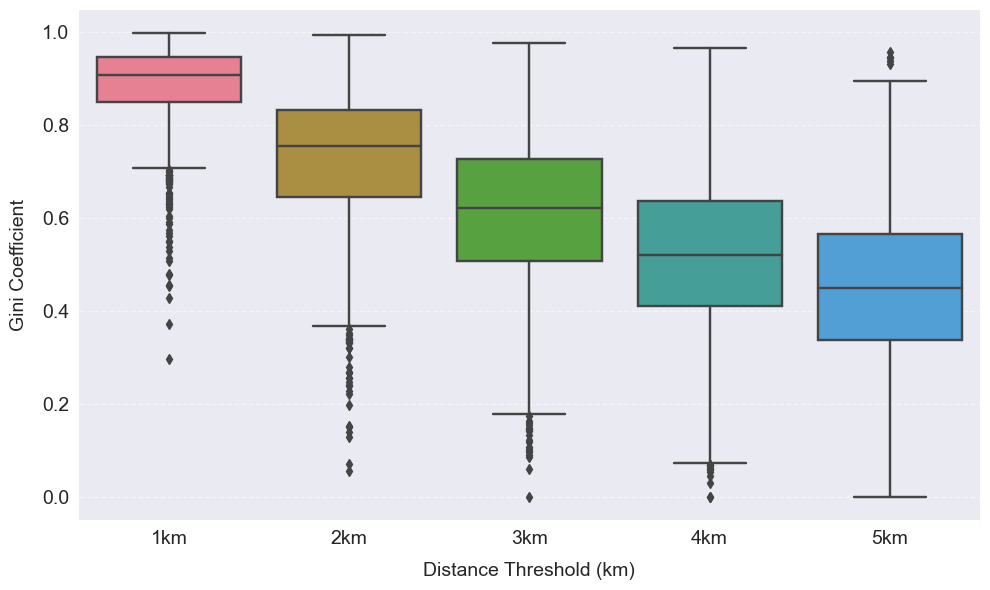


Descriptive Statistics by Distance:
          count      mean       std       min       25%       50%       75%  \
Distance                                                                      
1km       984.0  0.881694  0.094256  0.296746  0.849349  0.907723  0.945696   
2km       984.0  0.724648  0.154189  0.055210  0.644517  0.754218  0.831700   
3km       984.0  0.604061  0.171800  0.000000  0.506499  0.621039  0.725551   
4km       984.0  0.514905  0.175419  0.000000  0.410170  0.521185  0.636820   
5km       984.0  0.446780  0.173927  0.000000  0.336882  0.448815  0.565759   

               max  
Distance            
1km       0.996676  
2km       0.993123  
3km       0.974664  
4km       0.964447  
5km       0.957294  


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn')
sns.set_palette("husl")

# 1. Read the US city Gini coefficient data (without Supply_Type)
csv_file = 'merged_USA_gini_results_all_distances_no_supply.csv'
df = pd.read_csv(csv_file)

# 2. Reshape data from wide to long format
melted_df = df.melt(id_vars=['City'],  # Identifier variables
                    var_name='Distance',
                    value_name='Gini_Coefficient')

# 3. Extract distance information (e.g., 2km, 3km) and convert to ordered categorical
melted_df['Distance'] = melted_df['Distance'].str.extract('(\d+km)')
melted_df['Distance'] = pd.Categorical(
    melted_df['Distance'],
    categories=['1km', '2km', '3km', '4km', '5km'],
    ordered=True
)

# 4. Create the plot layout (single subplot)
fig, ax1 = plt.subplots(figsize=(10, 6))

# 5. Plot boxplot to show distribution of Gini coefficients across distances
sns.boxplot(data=melted_df, x='Distance', y='Gini_Coefficient', ax=ax1)

# Set font size for title and axis labels
# ax1.set_title('Overall Distribution of Gini Coefficients\nAcross Different Distances (USA Cities)', fontsize=15, pad=20)
ax1.set_xlabel('Distance Threshold (km)', fontsize=14, labelpad=10)
ax1.set_ylabel('Gini Coefficient', fontsize=14, labelpad=10)

# Adjust font size for all axis labels and tick labels
for item in ([ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(14)

# Add horizontal grid lines for better readability
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

# 6. Adjust layout and display the plot
plt.tight_layout()
# plt.suptitle('USA Cities Gini Coefficient Analysis', y=1.05, fontsize=15)
plt.show()

# 7. Additional analysis: Print descriptive statistics by distance
print("\nDescriptive Statistics by Distance:")
print(melted_df.groupby('Distance')['Gini_Coefficient'].describe())

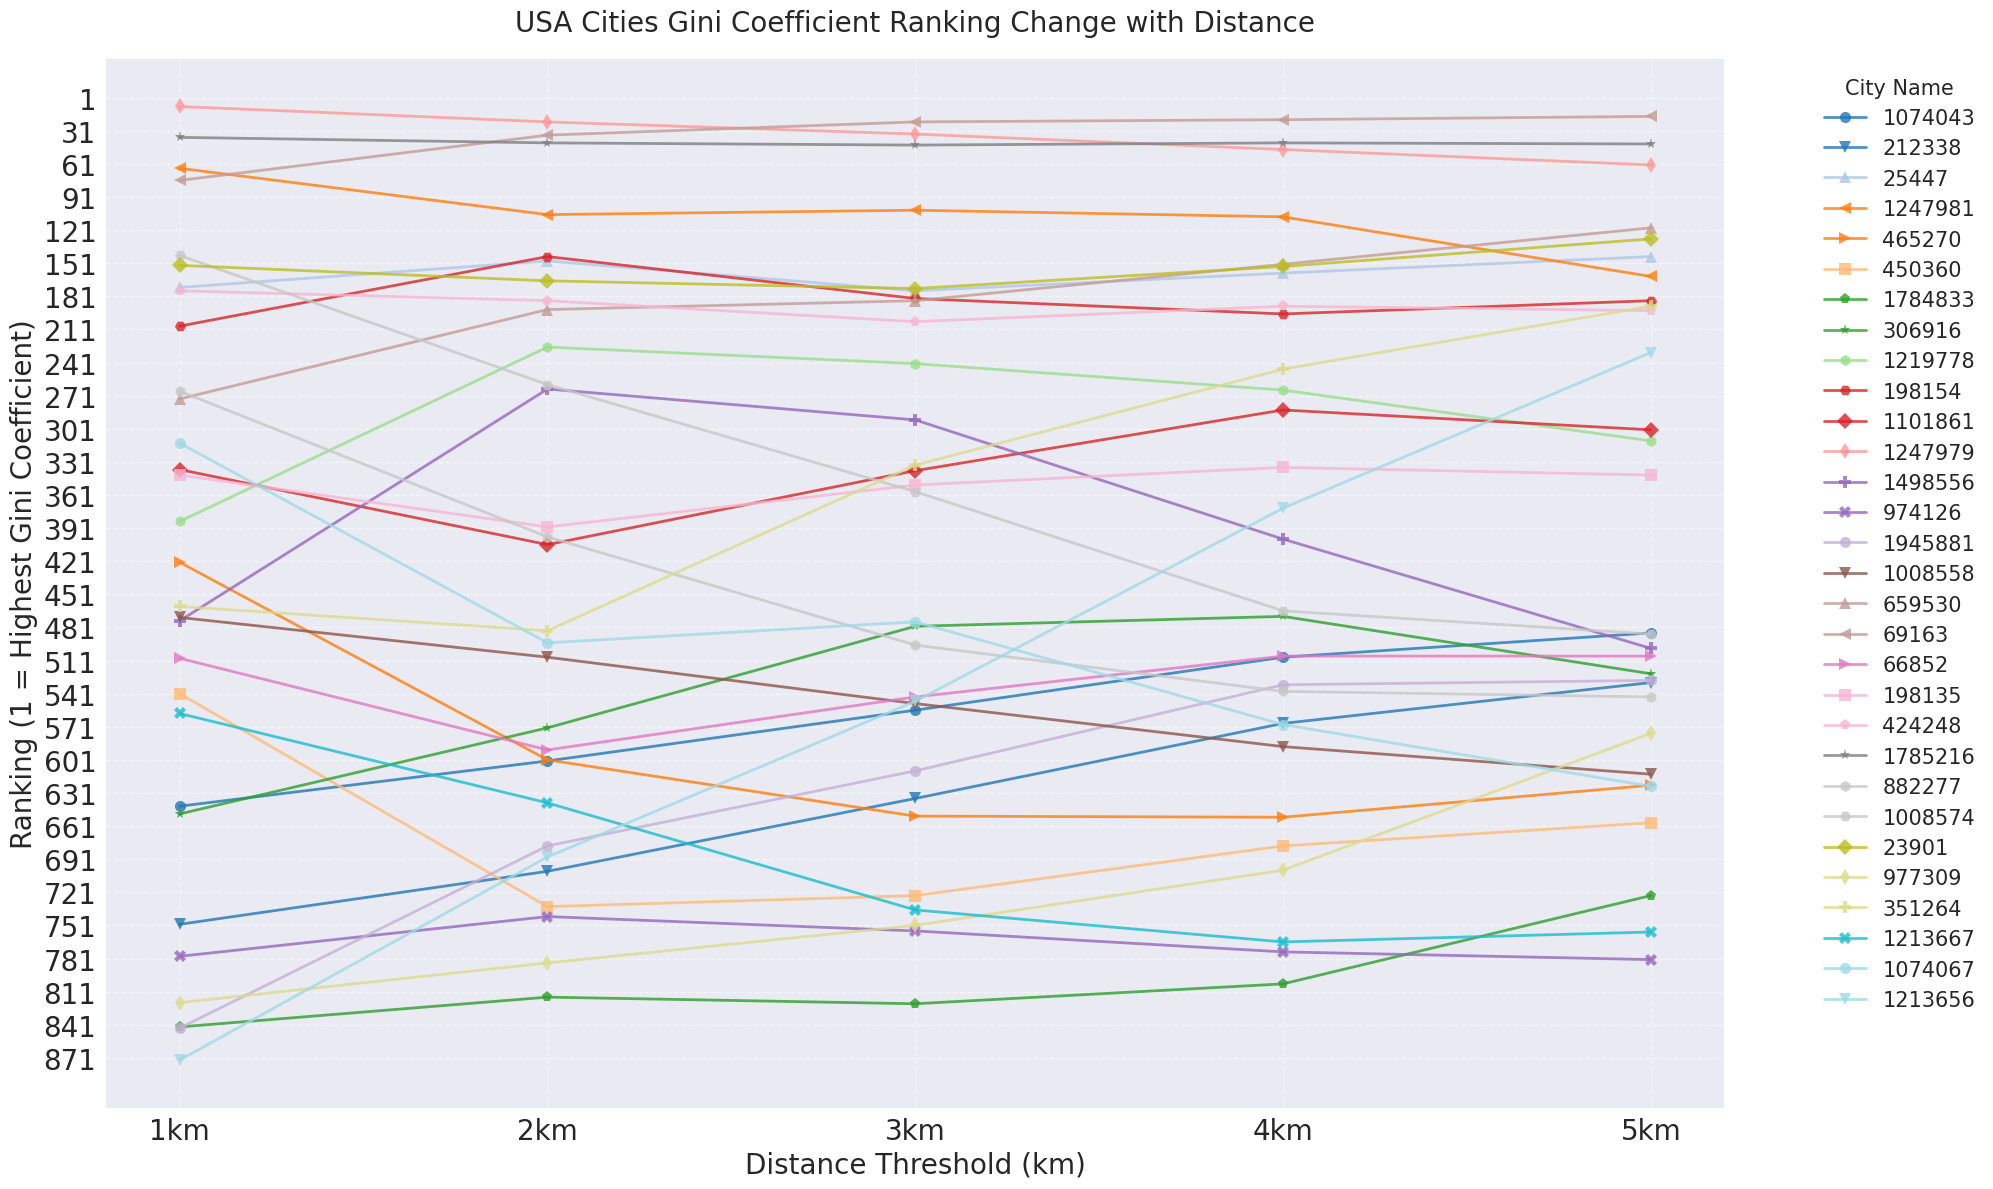

Randomly Selected 30 USA Cities: [1074043, 212338, 25447, 1247981, 465270, 450360, 1784833, 306916, 1219778, 198154, 1101861, 1247979, 1498556, 974126, 1945881, 1008558, 659530, 69163, 66852, 198135, 424248, 1785216, 882277, 1008574, 23901, 977309, 351264, 1213667, 1074067, 1213656]


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# Set font to support English characters
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # Display minus sign correctly

# Fix random seed for reproducibility
random.seed(42)

# 1. Load US city Gini coefficient data
csv_file = 'merged_USA_gini_results_all_distances.csv'
df = pd.read_csv(csv_file)

# 2. Randomly select 30 cities
selected_cities = random.sample(df['CountyNS'].unique().tolist(), 30)

# 3. Extract all columns related to Gini coefficients and calculate rankings for each distance
distance_columns = [col for col in df.columns if col.startswith('Gini_Coefficient')]
rank_dfs = []

for col in distance_columns:
    dist = col.replace('Gini_Coefficient', '')  # e.g., extract "2km"
    temp = df[['CountyNS', col]].copy()
    temp['Rank'] = temp[col].rank(ascending=False)  # Higher Gini coefficient means higher rank (lower numerical value)
    temp['Distance'] = dist
    rank_dfs.append(temp[['CountyNS', 'Distance', 'Rank']])

rank_df = pd.concat(rank_dfs)

# Filter down to the selected 30 cities
rank_df = rank_df[rank_df['CountyNS'].isin(selected_cities)]

# 4. Plot ranking changes over distances
plt.figure(figsize=(20, 12))

# Set colors and marker styles
colors = plt.cm.tab20(np.linspace(0, 1, len(selected_cities)))
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H',
           'D', 'd', 'P', 'X', 'o', 'v', '^', '<', '>', 's',
           'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v']

# Plot ranking change curves for each city
for i, city in enumerate(selected_cities):
    city_data = rank_df[rank_df['CountyNS'] == city]
    plt.plot(
        city_data['Distance'],
        city_data['Rank'],
        color=colors[i],
        marker=markers[i % len(markers)],
        markersize=8,
        linewidth=2,
        alpha=0.8,
        label=city
    )

# 5. Enhance plot aesthetics
plt.gca().invert_yaxis()  # Rank 1 at the top

# Set title and axis labels with font size of 16
plt.title('USA Cities Gini Coefficient Ranking Change with Distance', fontsize=20, pad=20)
plt.xlabel('Distance Threshold (km)', fontsize=20)
plt.ylabel('Ranking (1 = Highest Gini Coefficient)', fontsize=20)

# Set y-axis ticks: display fixed intervals, e.g., every 5th tick
max_rank = int(rank_df['Rank'].max())
yticks_step = 30
yticks = np.arange(1, max_rank + 1, yticks_step)
plt.yticks(yticks, fontsize=20)

# Set x-axis and y-axis tick font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Legend settings (automatic line breaks)
legend = plt.legend(bbox_to_anchor=(1.05, 1),
                   loc='upper left',
                   title='City Name',
                   fontsize=15,  # Legend text size
                   title_fontsize=15,  # Legend title size
                   ncol=1)

# Grid and layout adjustments
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

# Output the list of selected cities (for record-keeping or debugging purposes)
print("Randomly Selected 30 USA Cities:", selected_cities)